In [1]:
import pickle

with open('..\stubs/reformated_tracks_stubs.pkl', 'rb') as f:
    reformatted_tracks = pickle.load(f)

In [2]:
reformatted_tracks = {
        track_id: track_info
        for track_id, track_info in reformatted_tracks.items()
        if len(track_info['num_frames']) > 0
    }

In [3]:
import matplotlib.pyplot as plt

def display_player_team(reformatted_tracks, player_id):
    dict_player = reformatted_tracks[player_id]
    plt.scatter(dict_player['num_frames'], dict_player['team_id'], marker='o')
    plt.xlabel("Frame")
    plt.ylabel("Team")
    plt.title(f"Player id: {player_id}")
    plt.show()

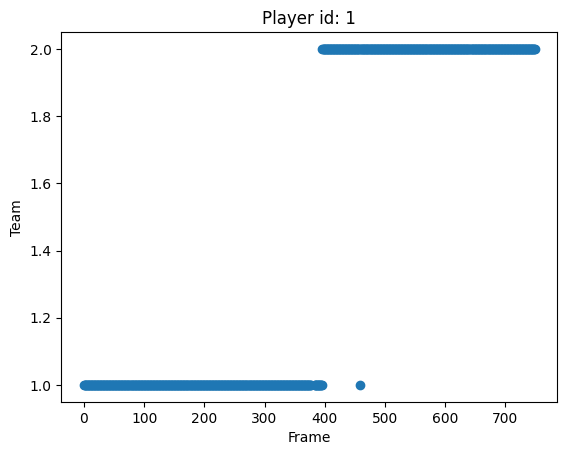

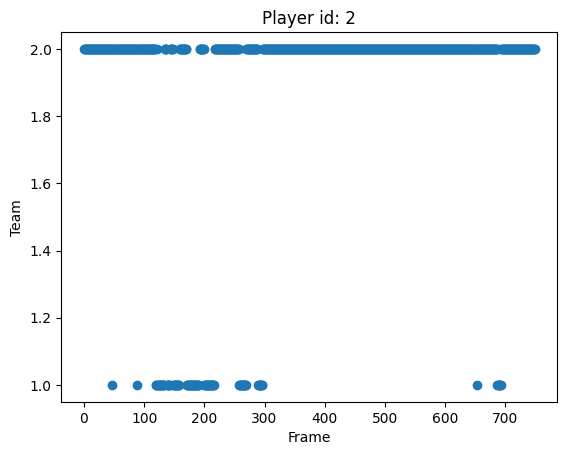

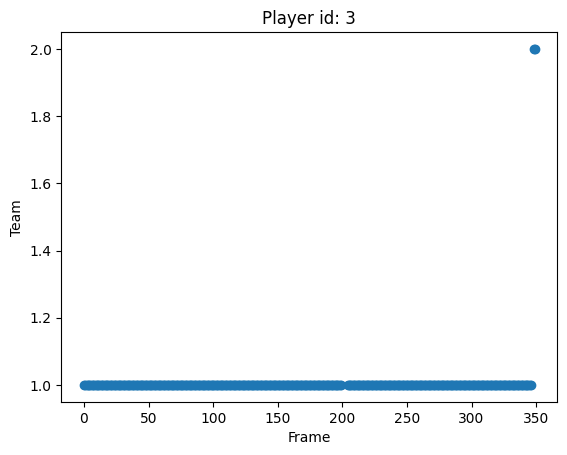

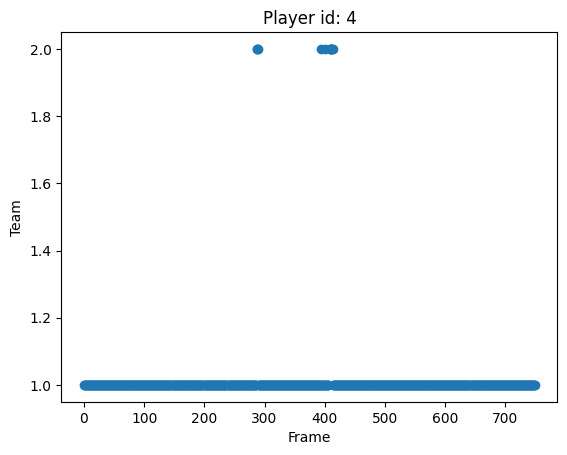

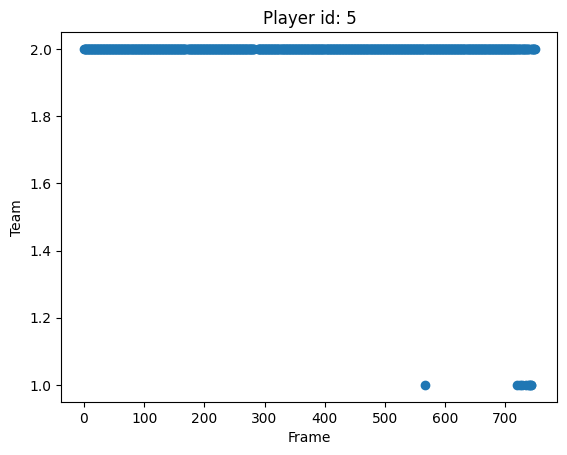

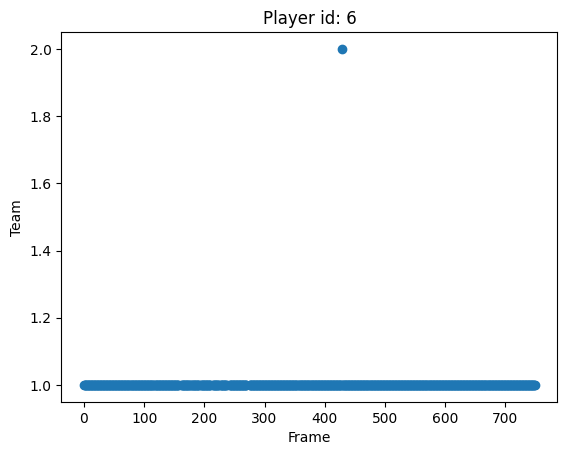

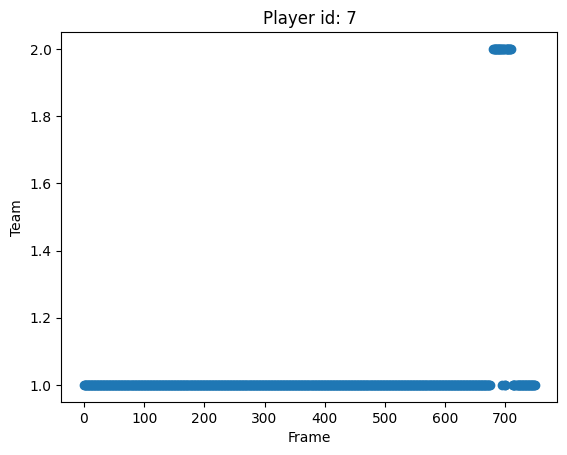

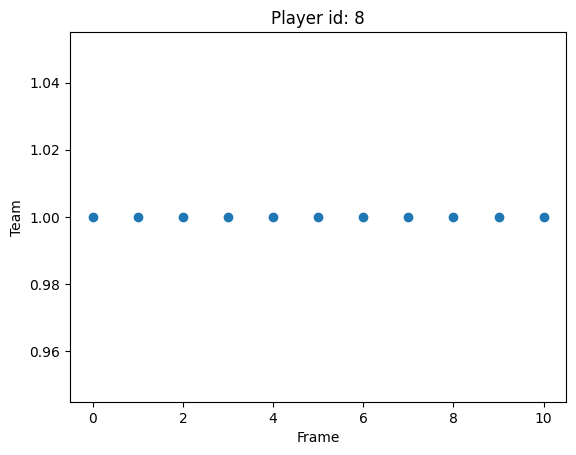

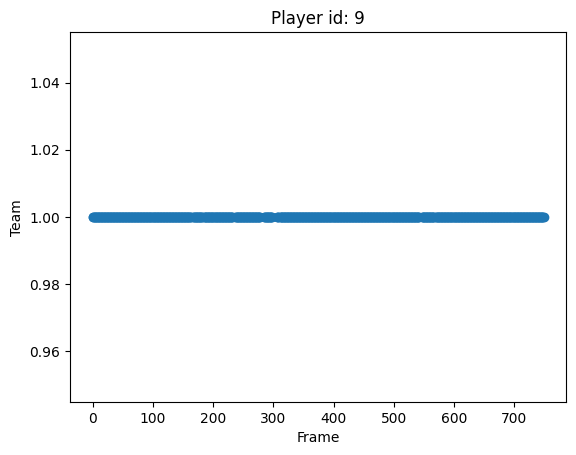

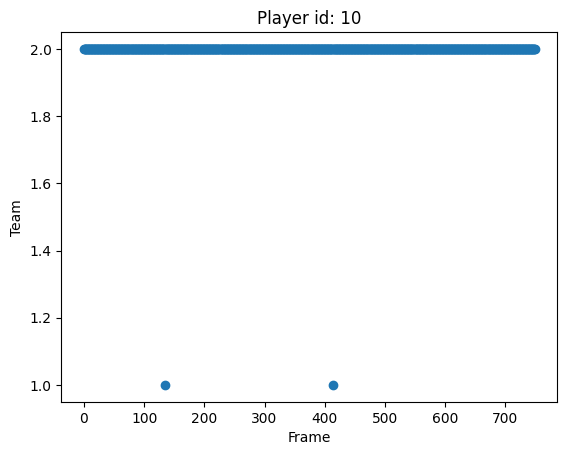

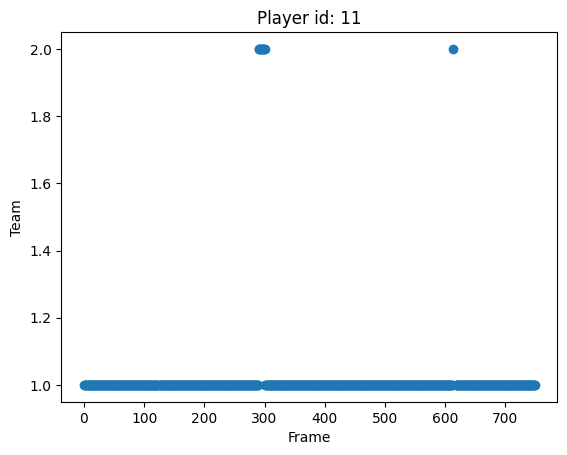

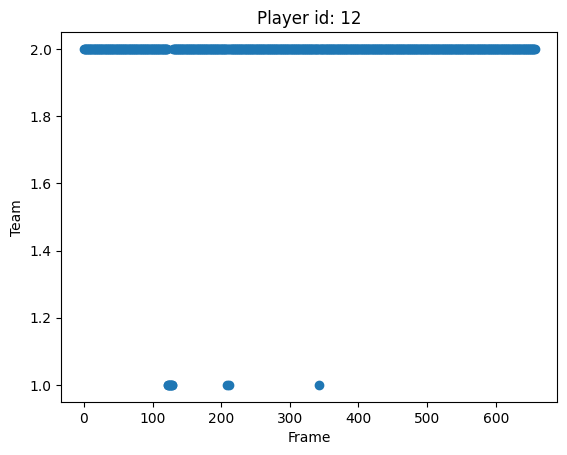

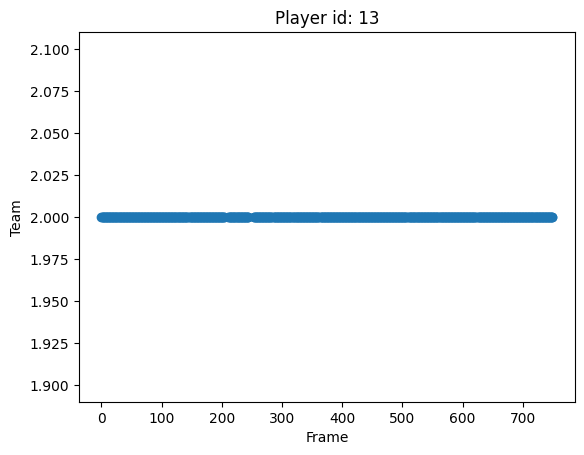

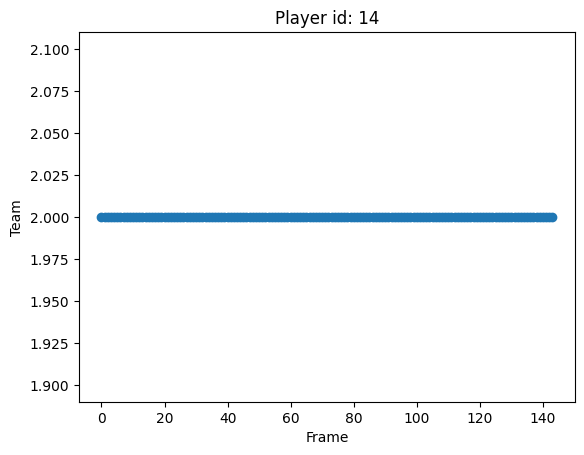

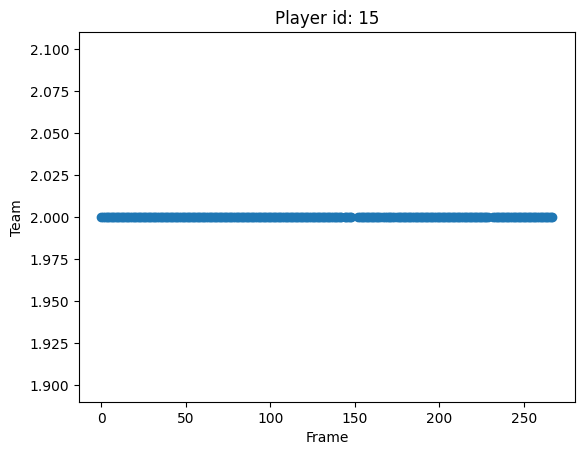

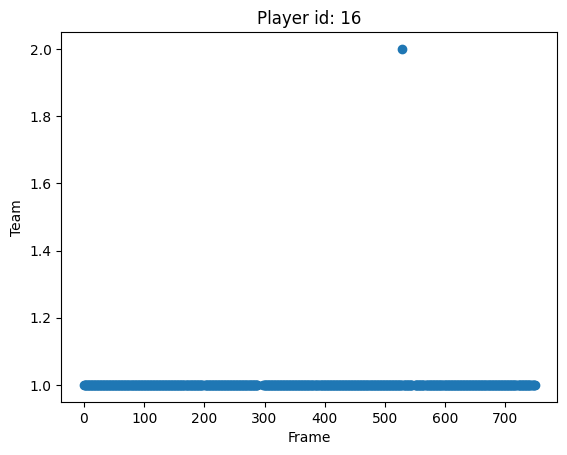

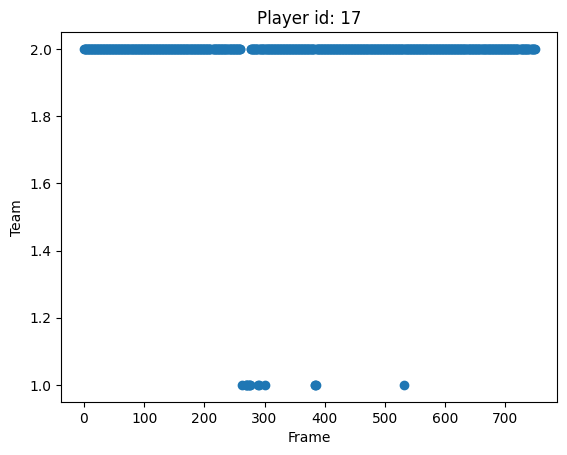

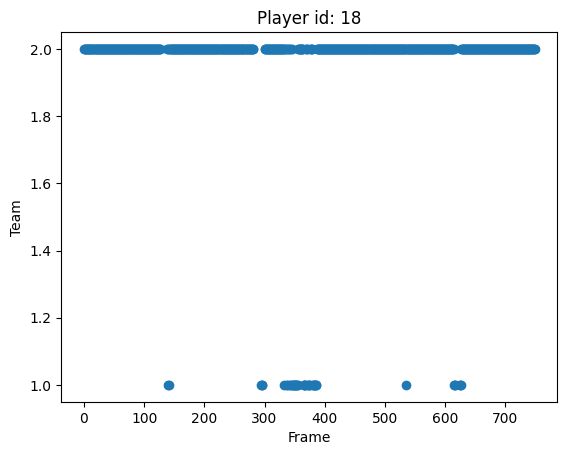

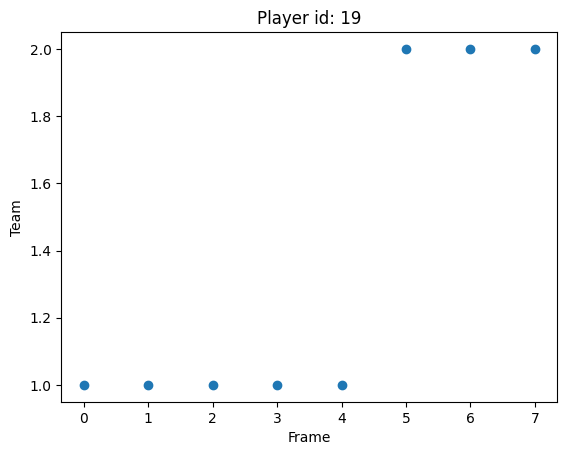

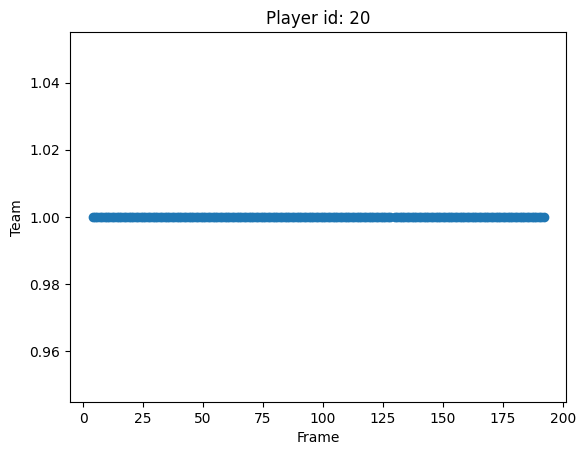

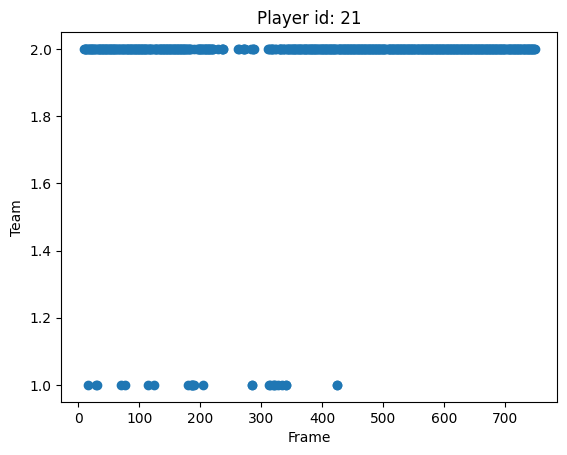

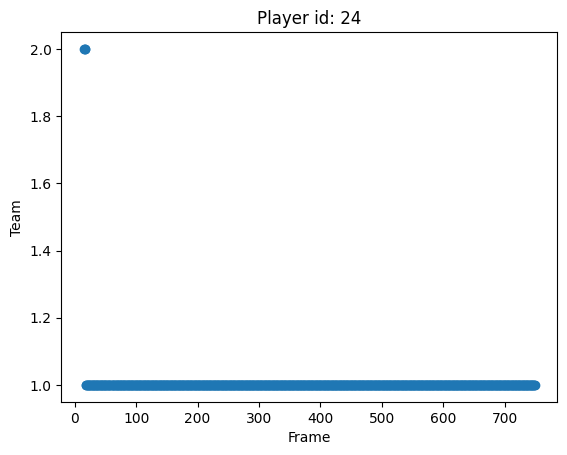

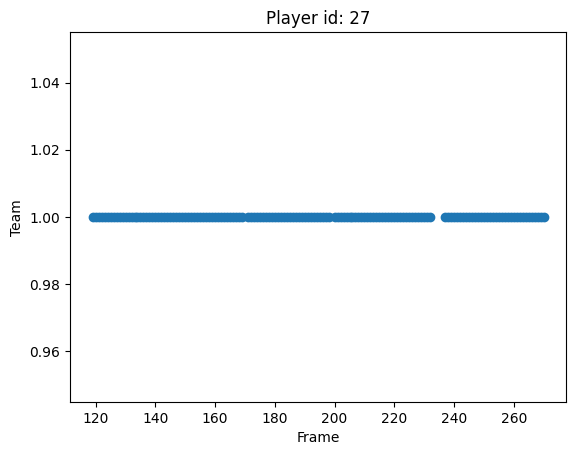

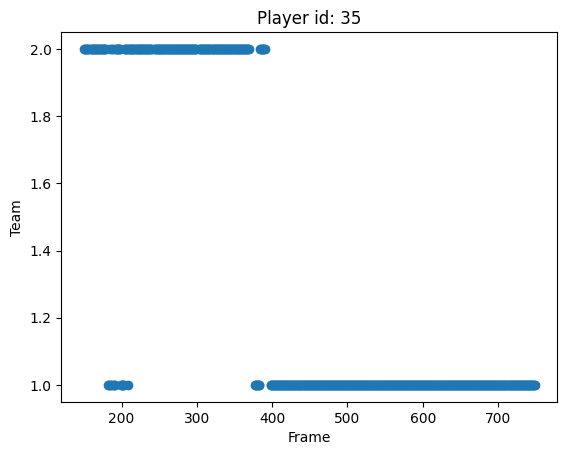

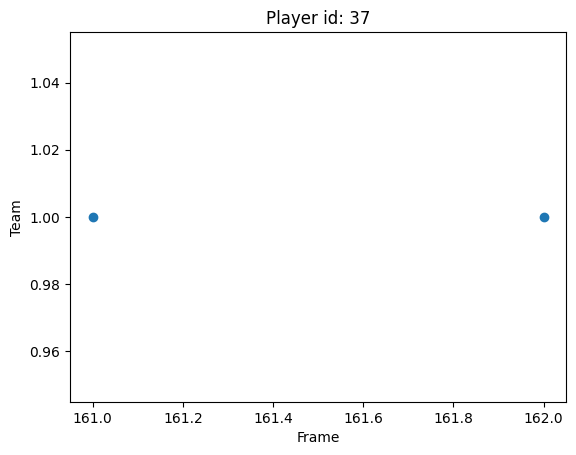

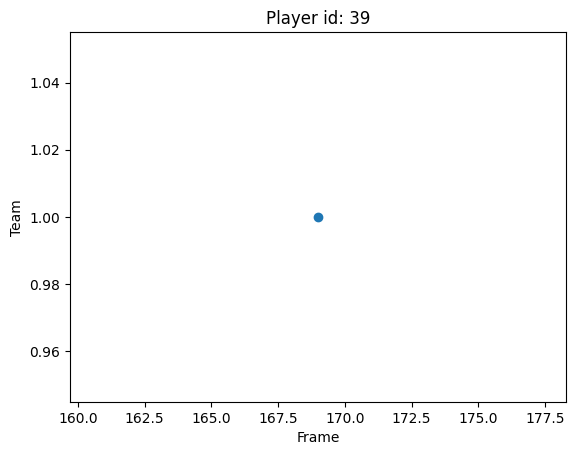

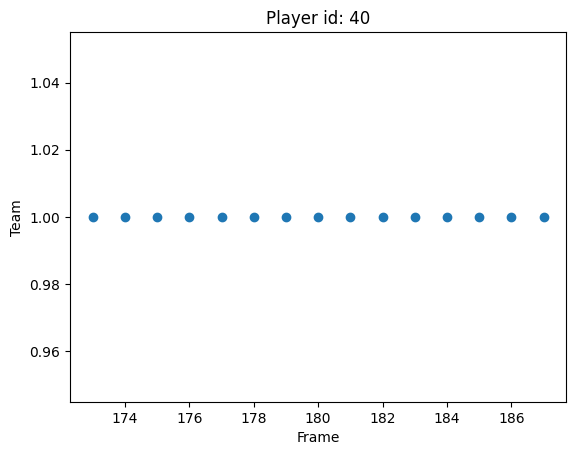

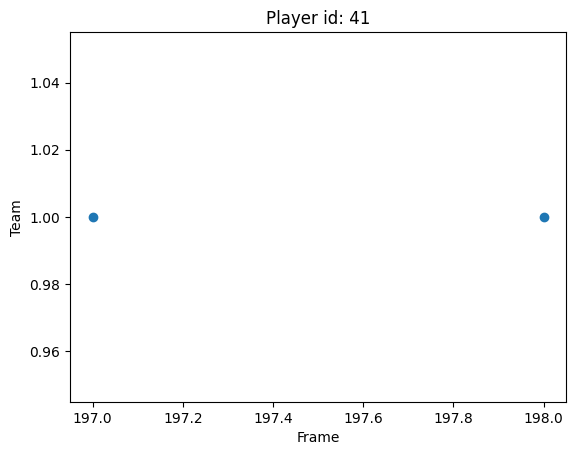

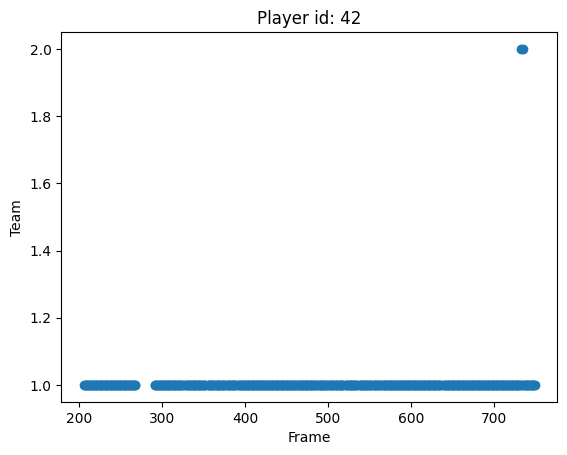

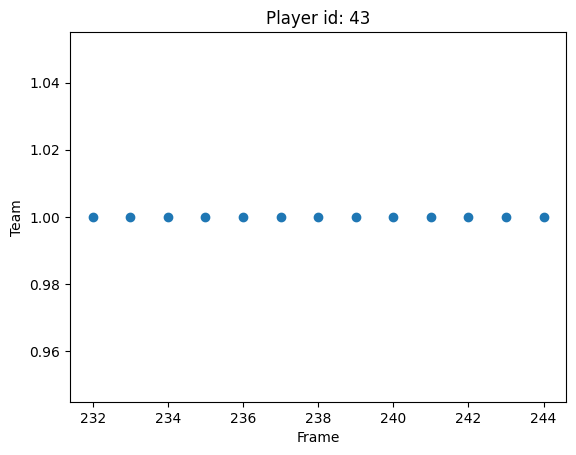

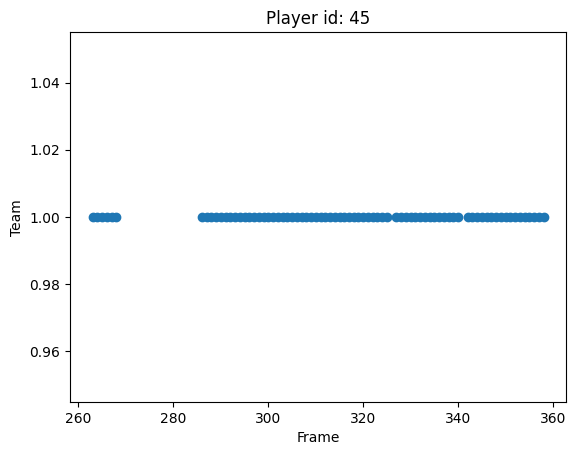

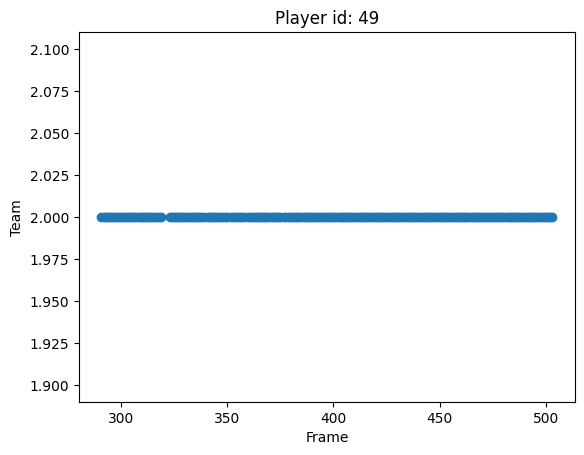

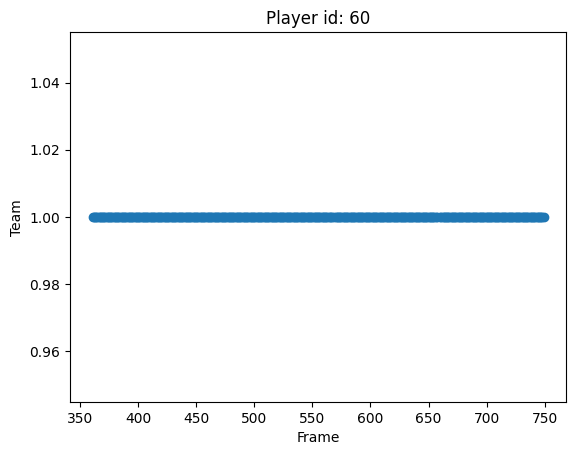

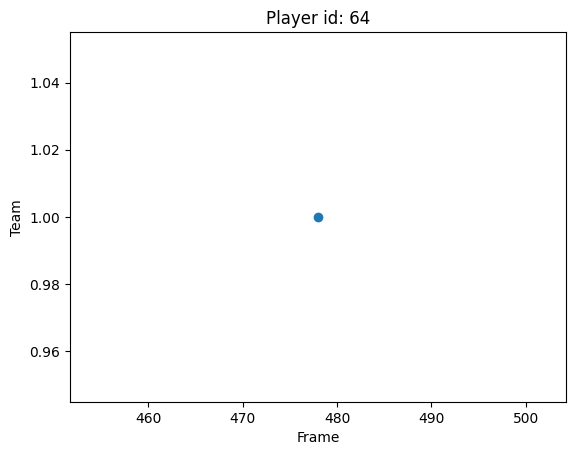

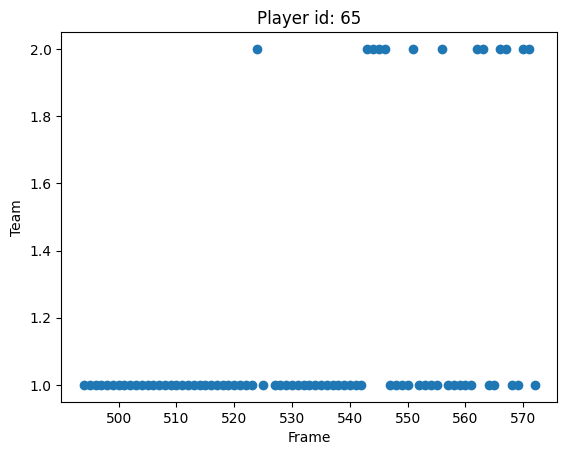

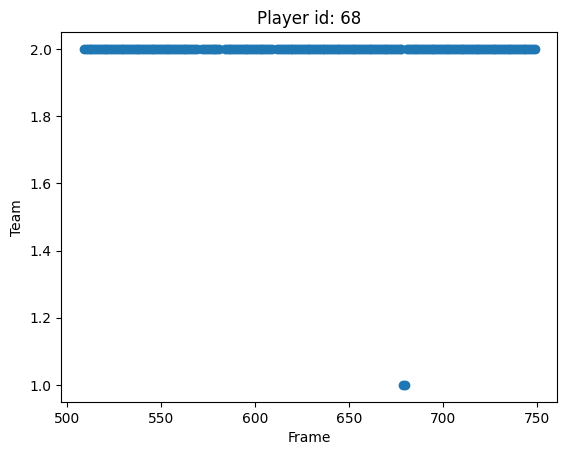

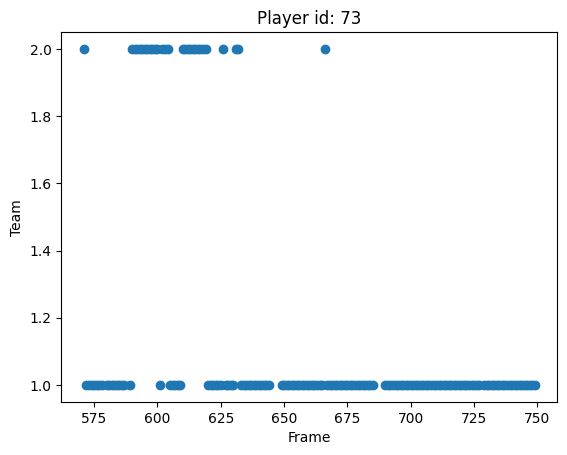

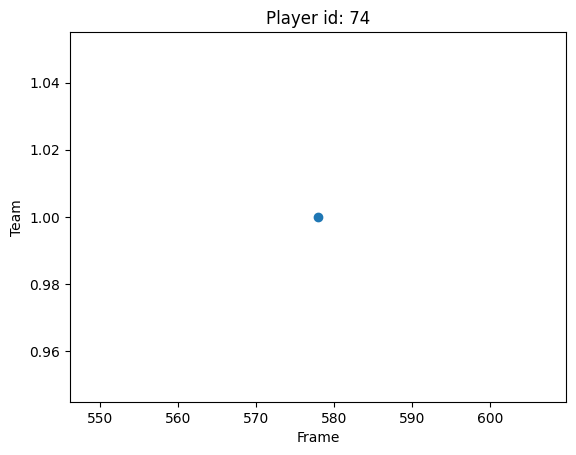

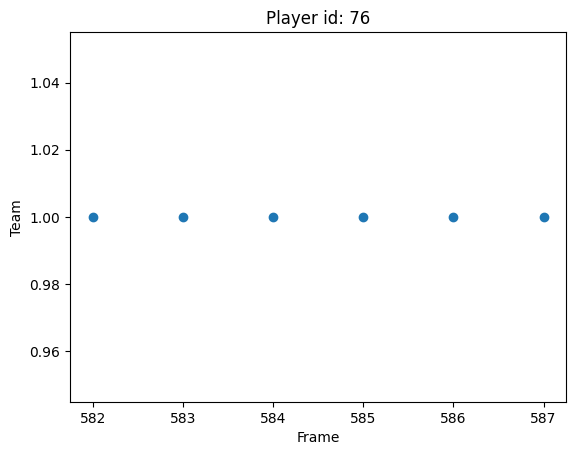

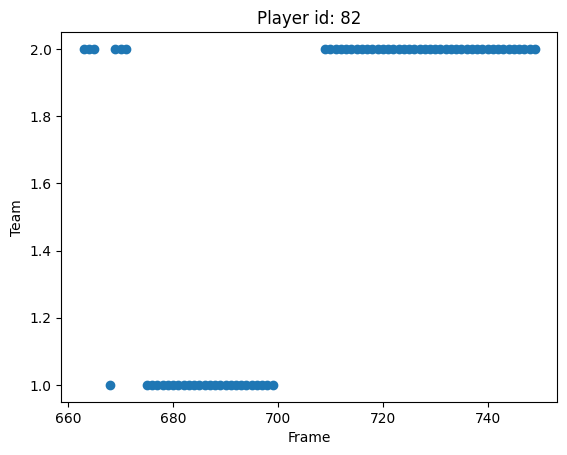

In [4]:
for tracking_id in reformatted_tracks.keys():
    display_player_team(reformatted_tracks, player_id=tracking_id)

In [5]:
import pandas as pd
from scipy.stats import mode

def correct_team_assignments(reformatted_tracks, tracking_id, window_size):
    frames = reformatted_tracks[tracking_id]['num_frames']
    teams = reformatted_tracks[tracking_id]['team_id']

    window_size = len(frames) if len(frames) < window_size else window_size

    df = pd.DataFrame({'frame': frames, 'team': teams})
    df['corrected_team'] = df['team'].rolling(window=window_size, center=True).apply(lambda x: mode(x)[0] if len(x) > 0 else x)
    df['corrected_team'] = df['corrected_team'].ffill().bfill()

    reformatted_tracks[tracking_id]['team_id'] = df['corrected_team'].astype(int).tolist()

    return reformatted_tracks


In [6]:
for tracking_id in reformatted_tracks.keys():
    reformatted_tracks = correct_team_assignments(reformatted_tracks, tracking_id, window_size=24)

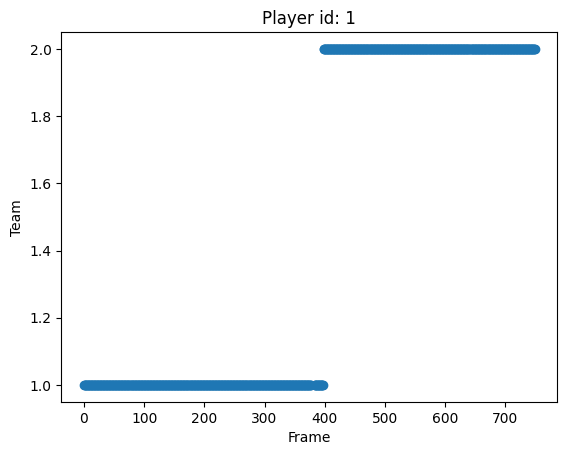

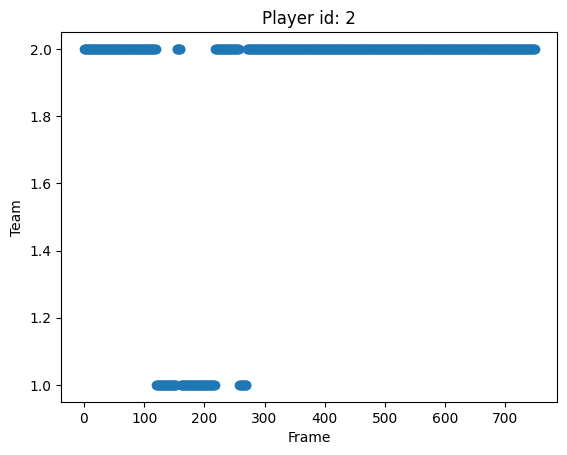

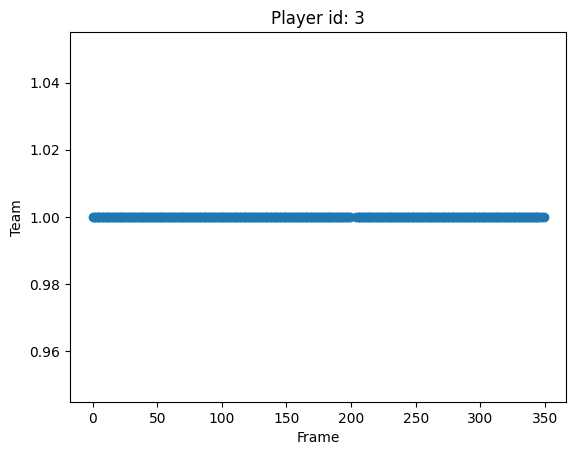

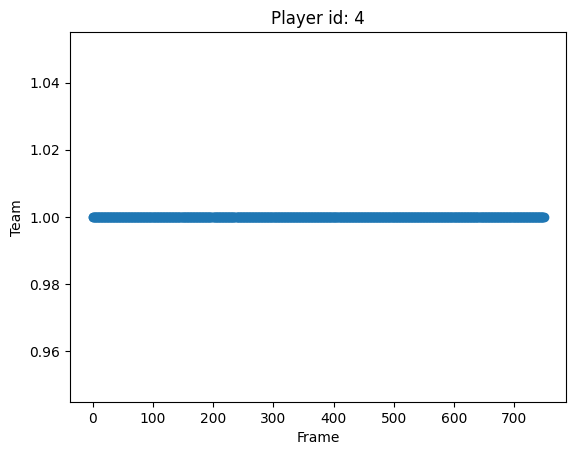

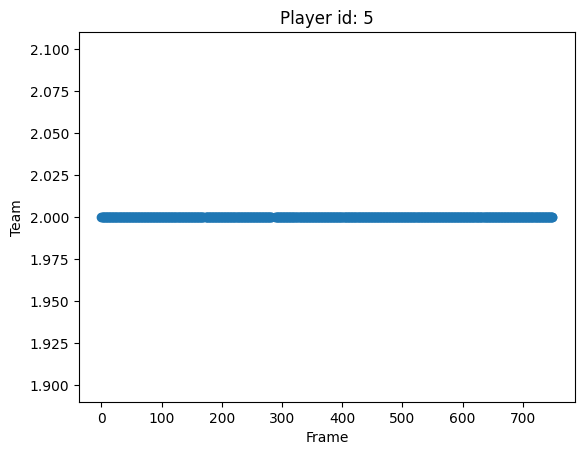

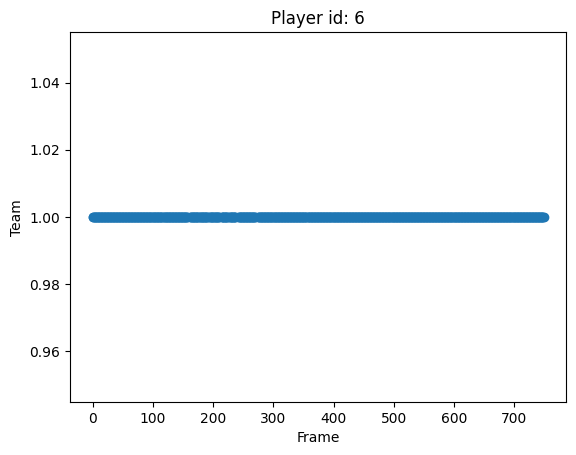

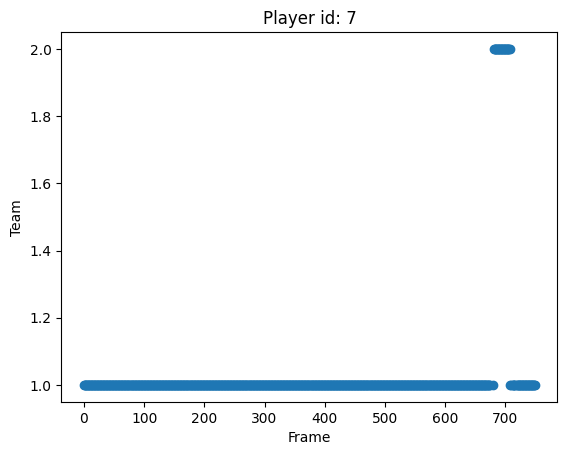

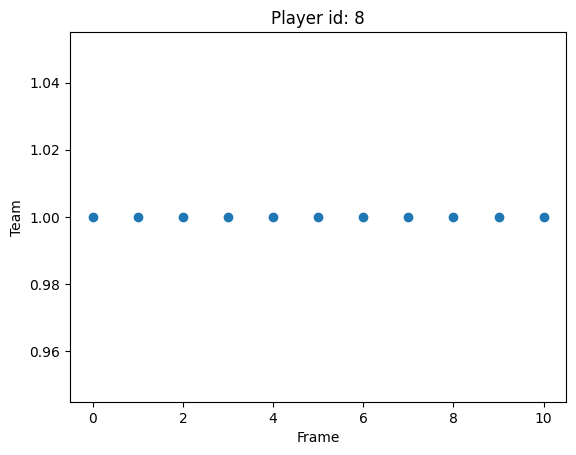

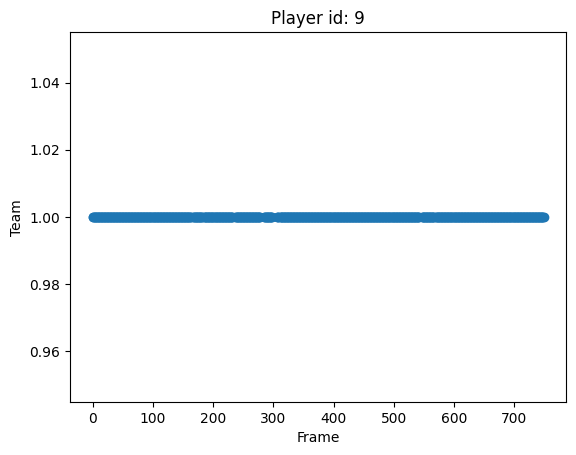

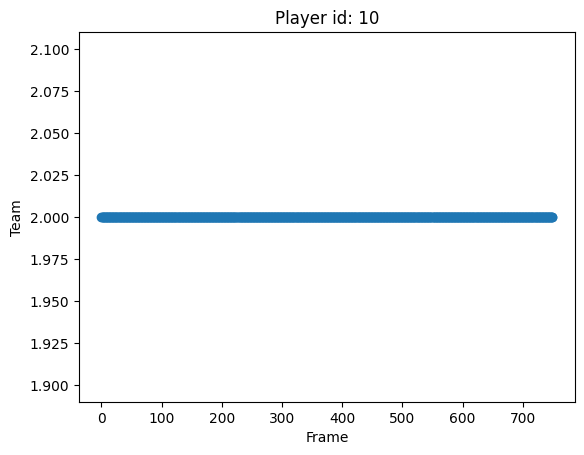

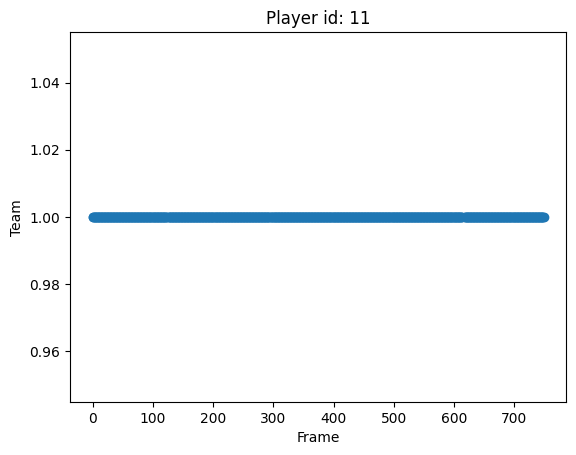

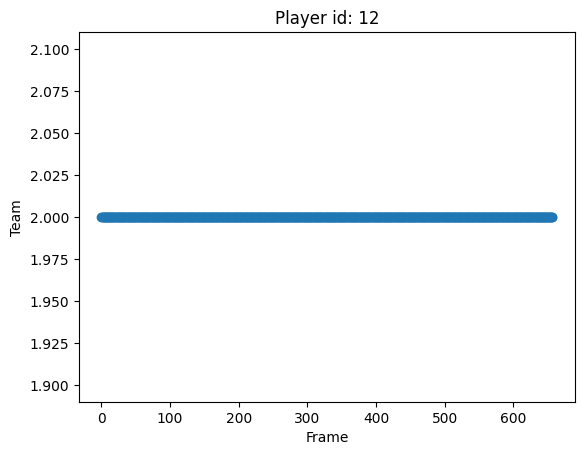

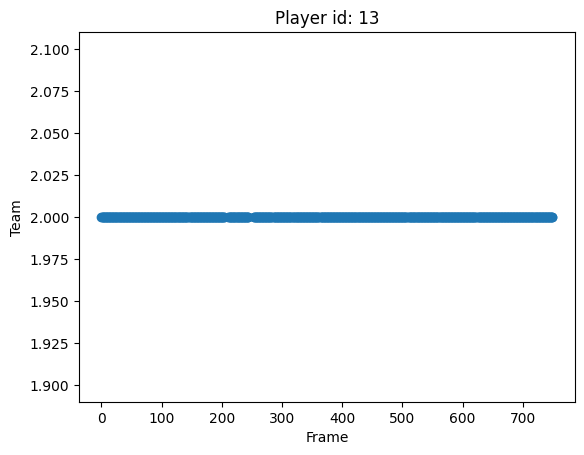

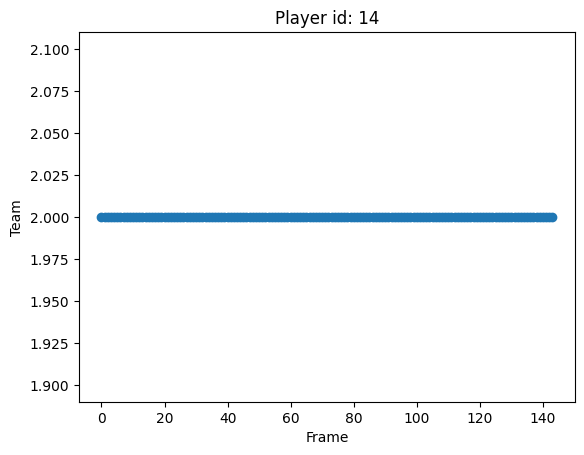

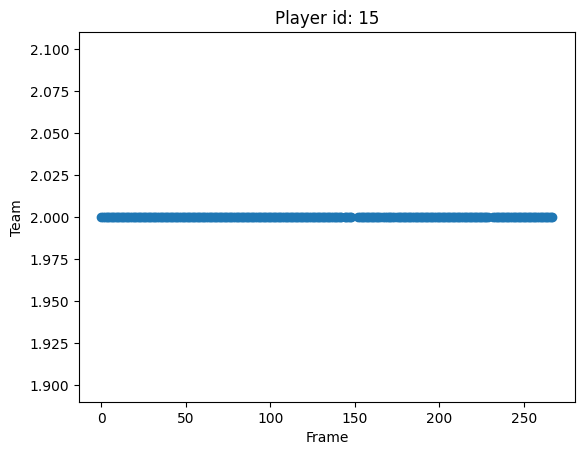

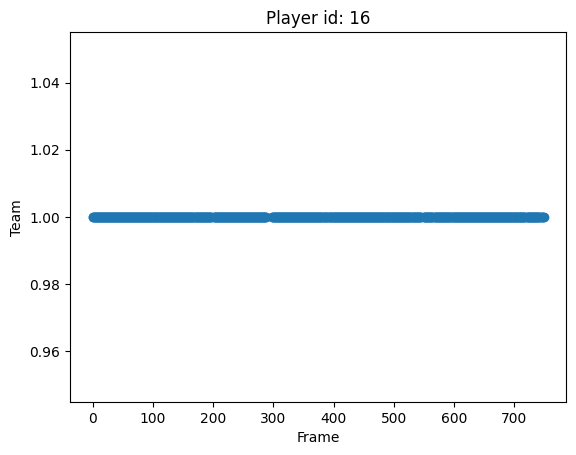

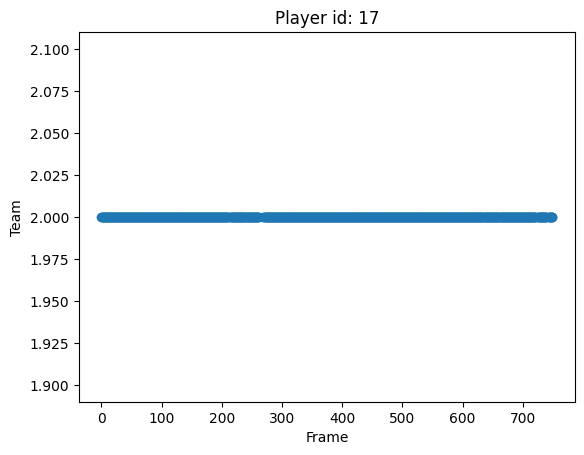

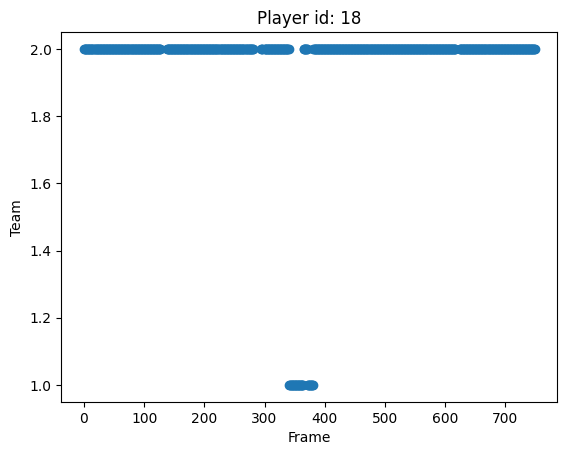

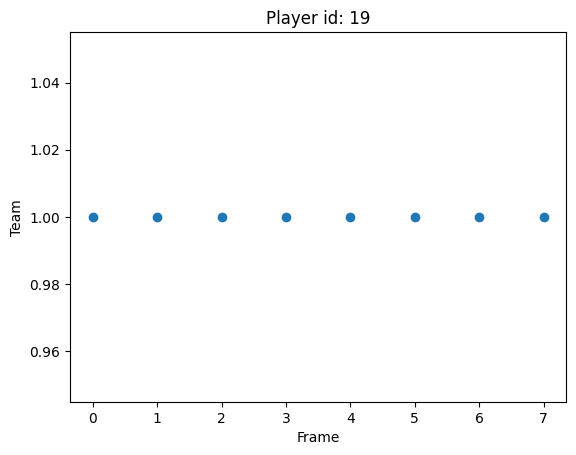

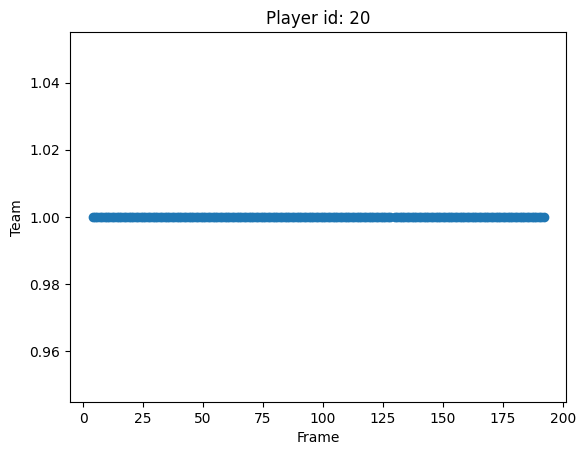

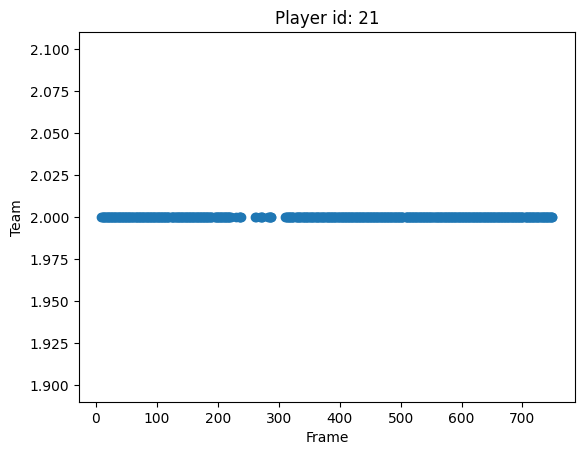

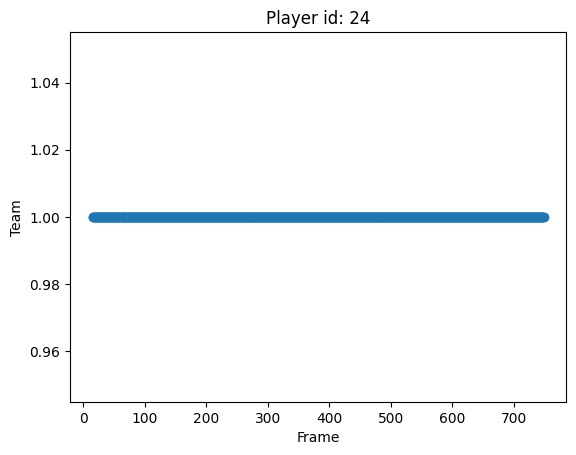

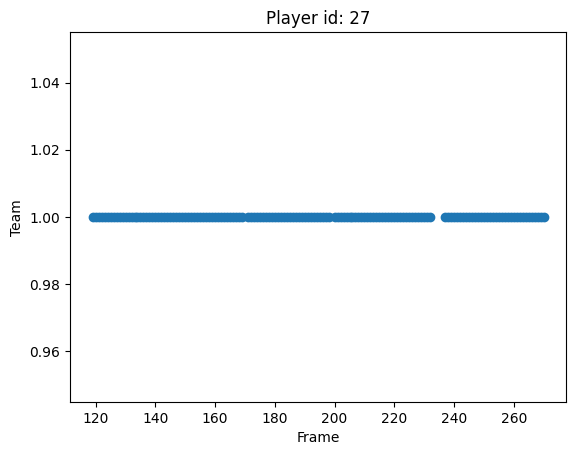

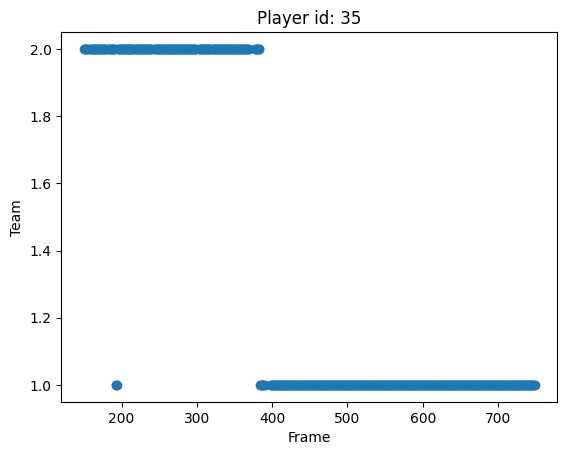

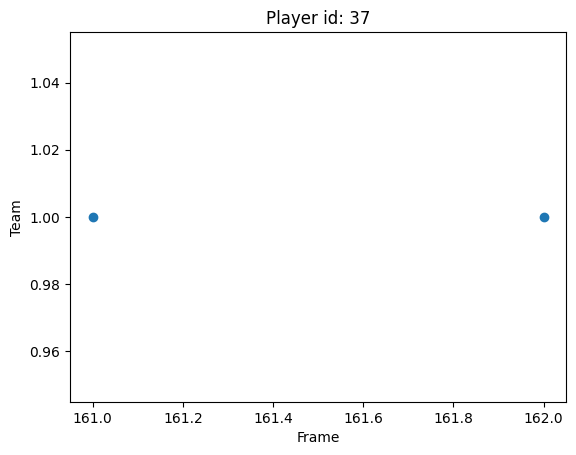

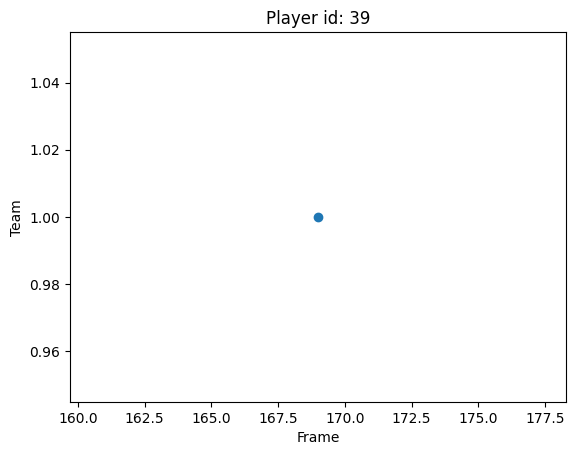

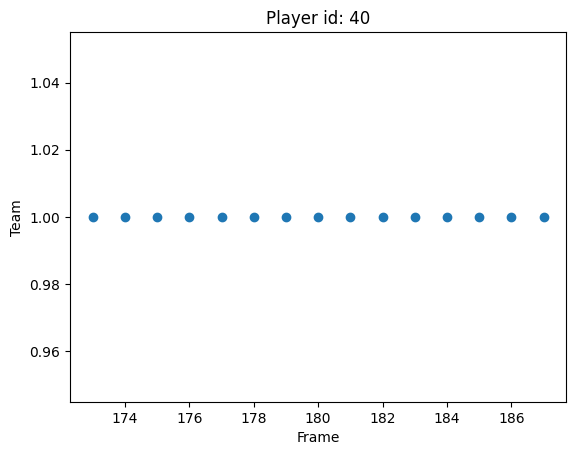

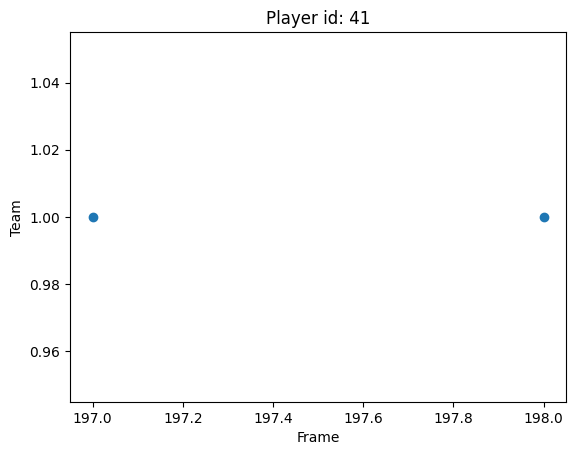

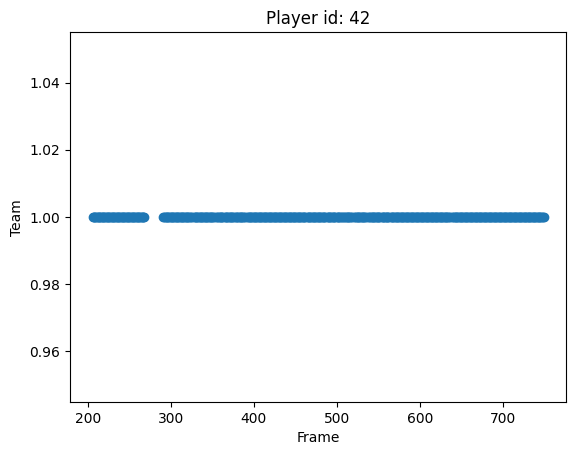

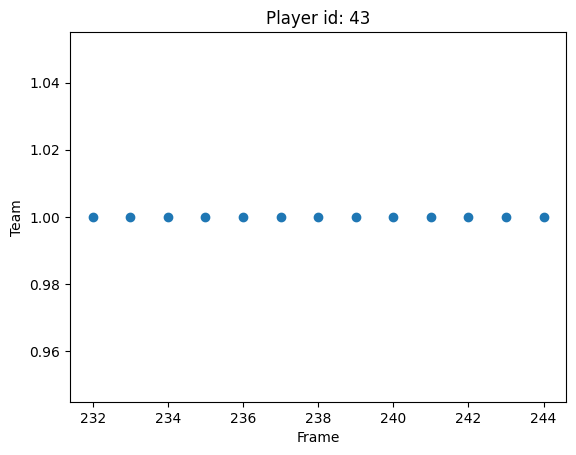

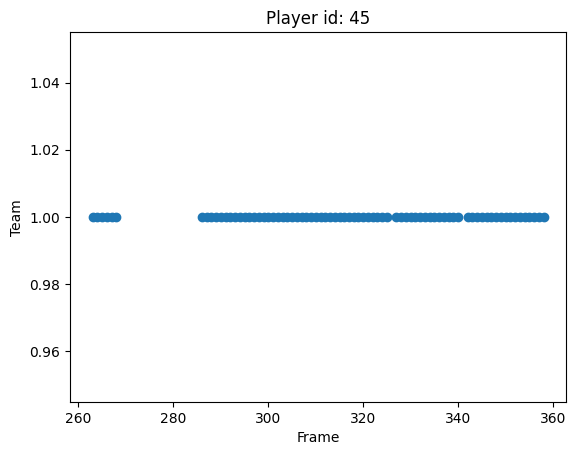

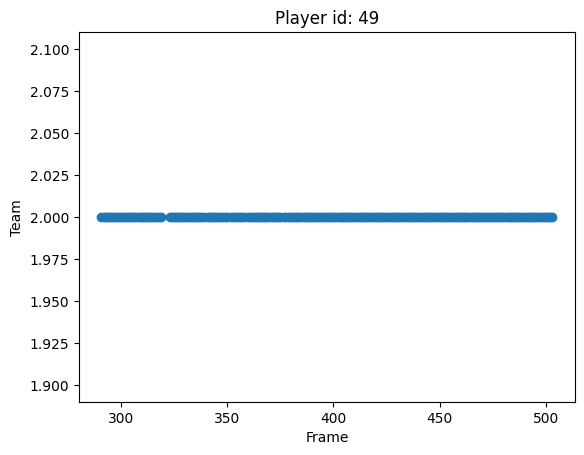

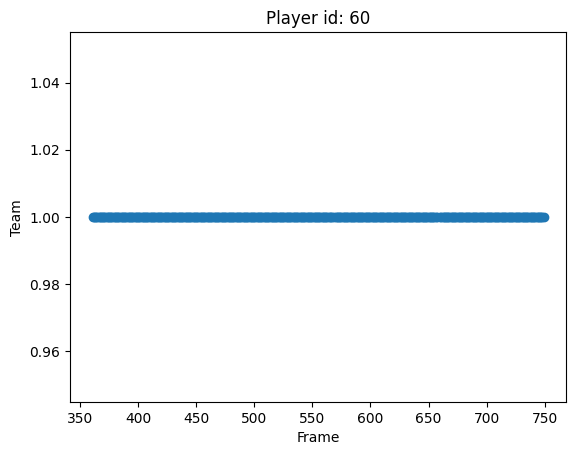

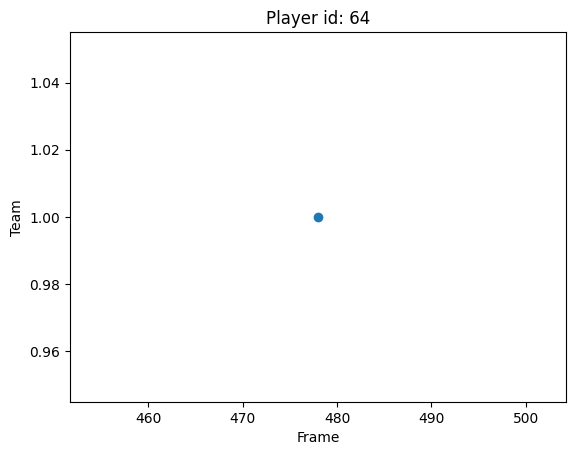

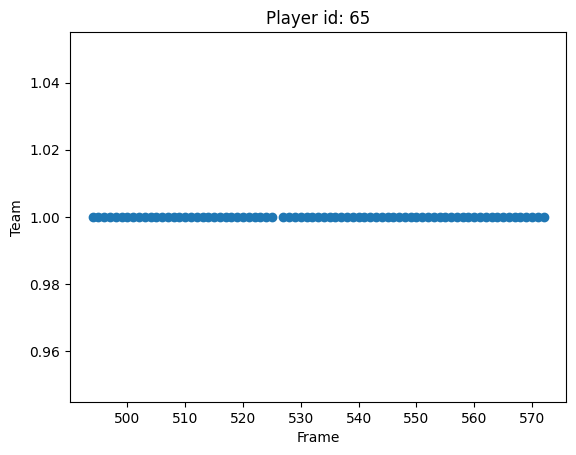

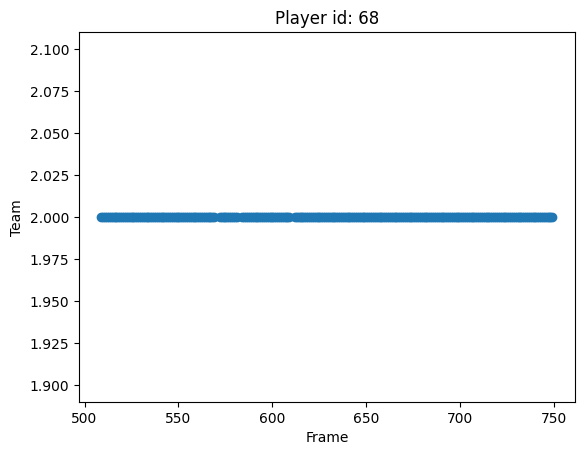

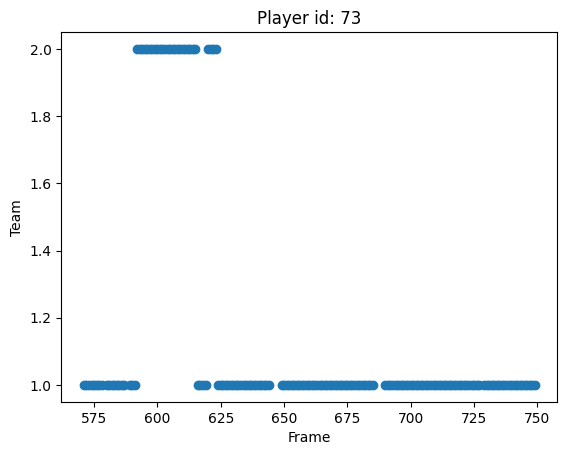

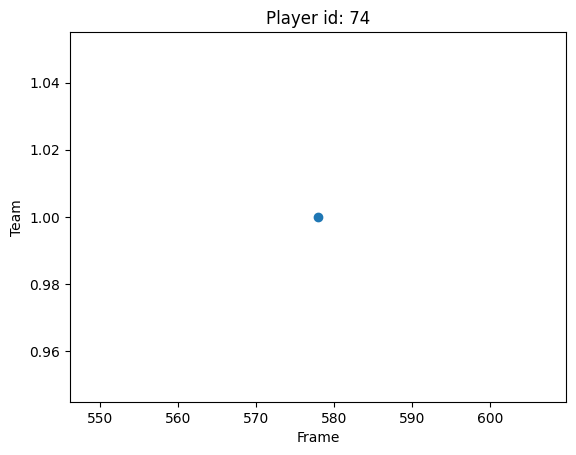

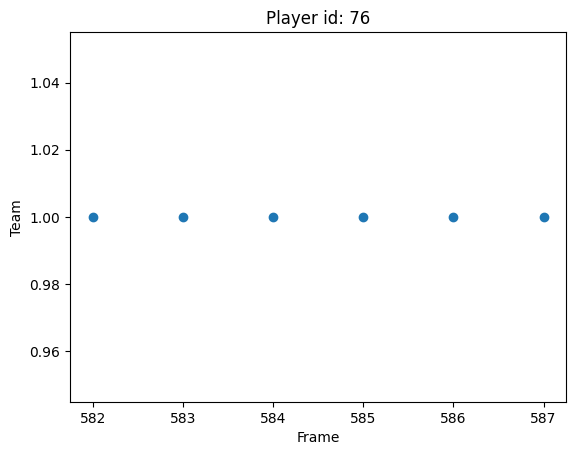

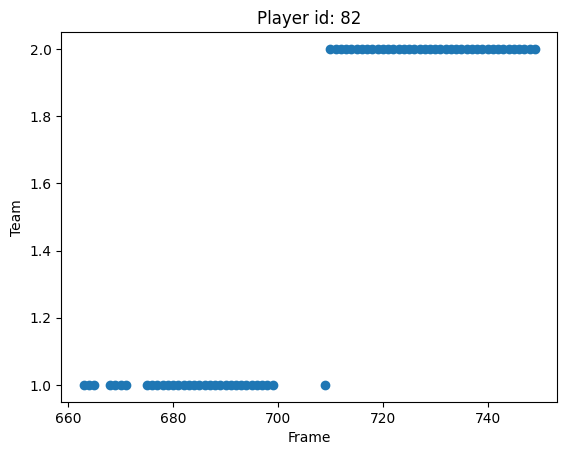

In [7]:
for tracking_id in reformatted_tracks.keys():
    display_player_team(reformatted_tracks, player_id=tracking_id)

In [8]:
import numpy as np

def correct_team_assignment_if_isolated(reformatted_tracks, distance_threshold=50):

    for tracking_id, player_info in reformatted_tracks.items():
        frames = player_info['num_frames']
        teams = player_info['team_id']
        bboxes = player_info['bbox']
        
        df = pd.DataFrame({'frame': frames, 'team': teams, 'bbox': bboxes})
        
        for i in range(1, len(df)):
            if df.loc[i, 'team'] != df.loc[i - 1, 'team']:
                current_bbox = df.loc[i, 'bbox']
                current_frame = df.loc[i, 'frame']
                
                is_isolated = True
                for other_tracking_id, other_info in reformatted_tracks.items():
                    if other_tracking_id == tracking_id:
                        continue  
                    
                    if current_frame in other_info['num_frames']:
                        other_index = other_info['num_frames'].index(current_frame)
                        other_bbox = other_info['bbox'][other_index]
                        
                        distance = np.linalg.norm(
                            np.array([current_bbox[0] + current_bbox[2], current_bbox[1] + current_bbox[3]]) / 2 -
                            np.array([other_bbox[0] + other_bbox[2], other_bbox[1] + other_bbox[3]]) / 2
                        )
                        
                        if distance < distance_threshold:
                            is_isolated = False
                            break
                
                if is_isolated:
                    df.loc[i, 'team'] = df.loc[i - 1, 'team']
        
        reformatted_tracks[tracking_id]['team_id'] = df['team'].tolist()

    return reformatted_tracks


In [9]:
for tracking_id in reformatted_tracks.keys():
    reformatted_tracks = correct_team_assignment_if_isolated(reformatted_tracks)

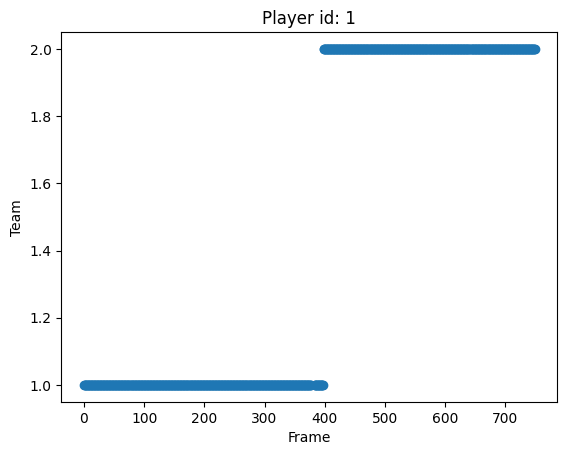

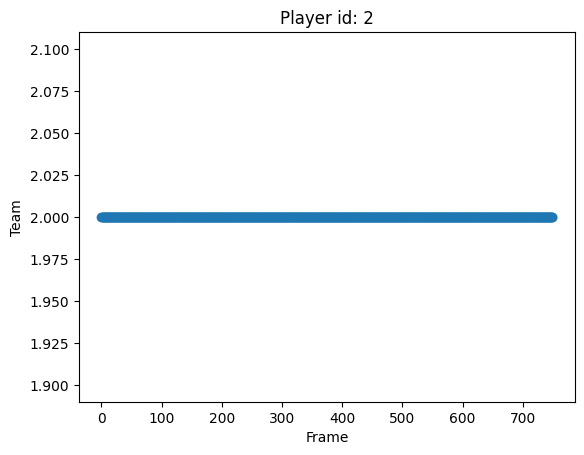

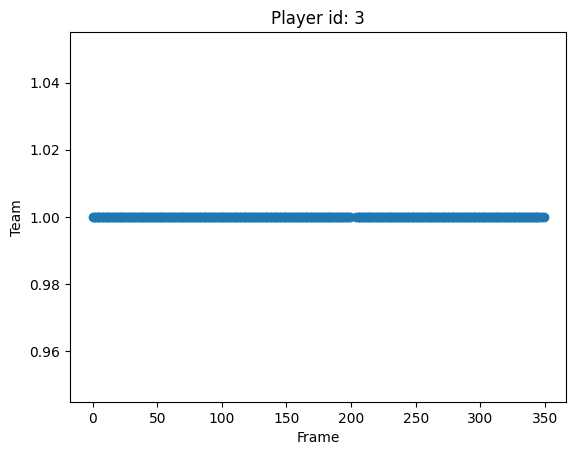

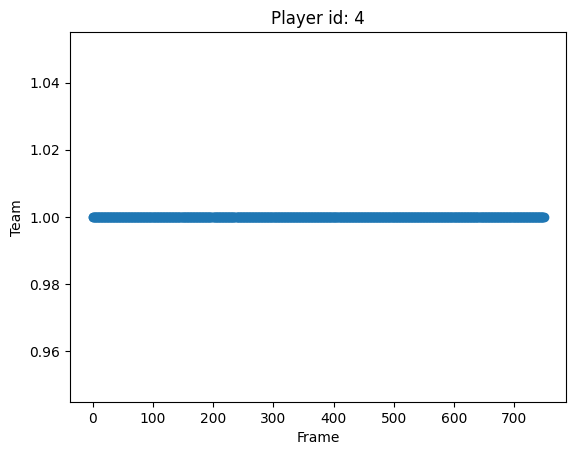

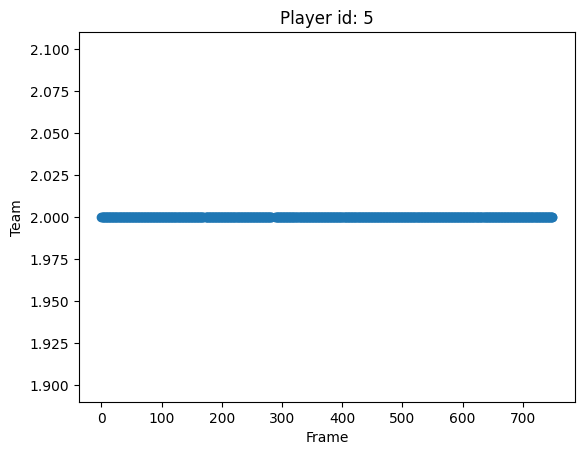

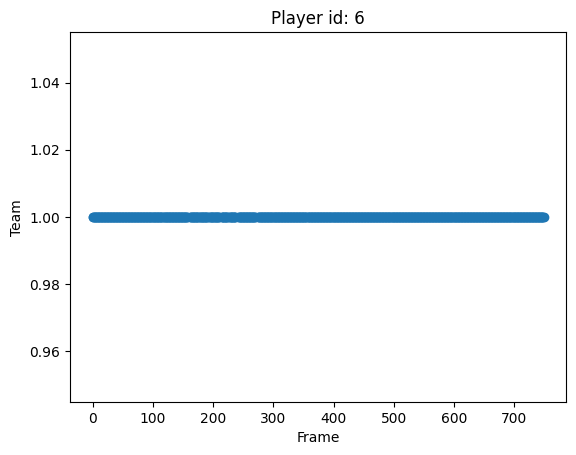

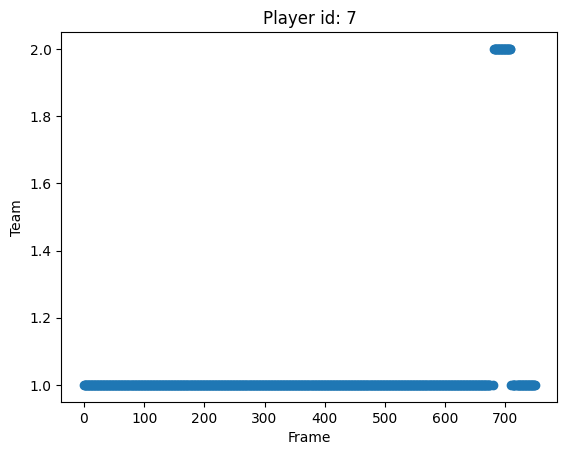

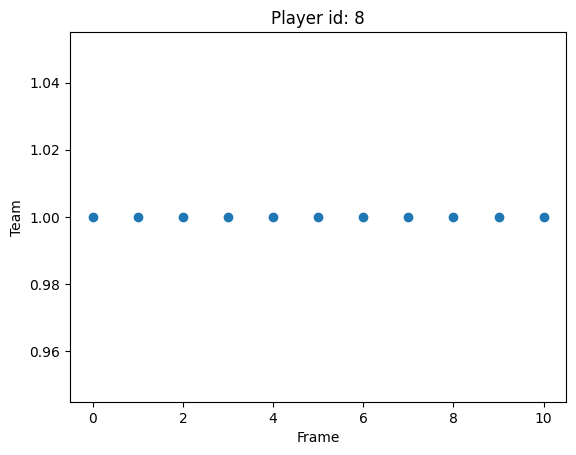

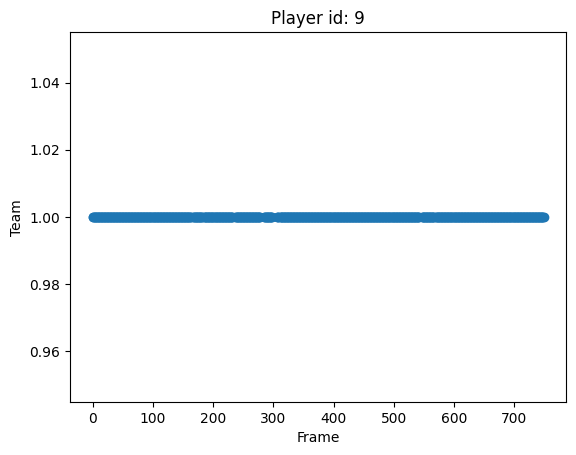

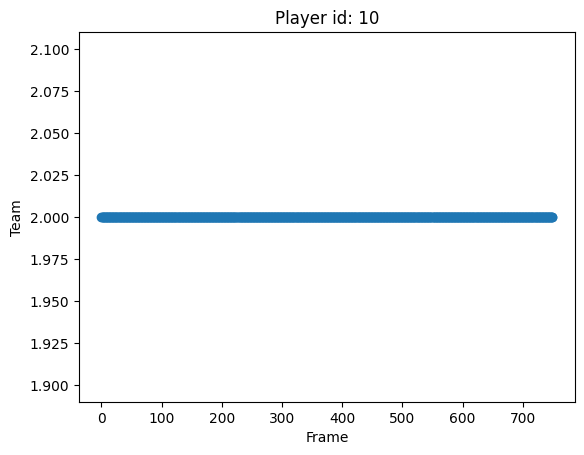

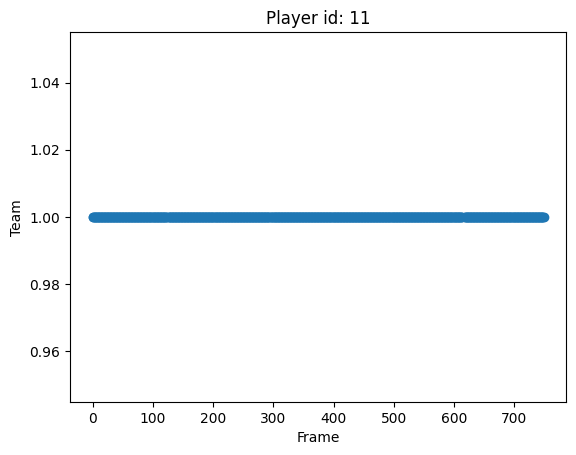

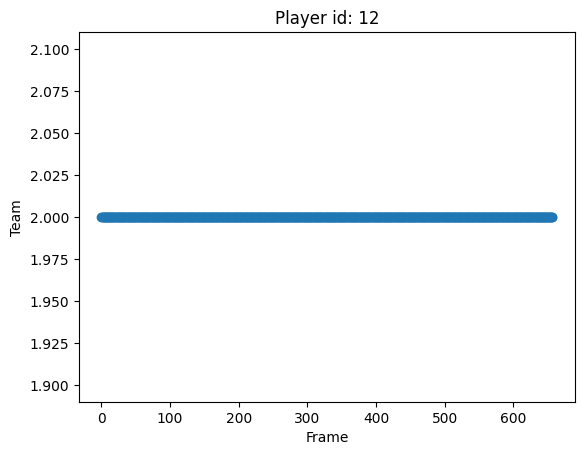

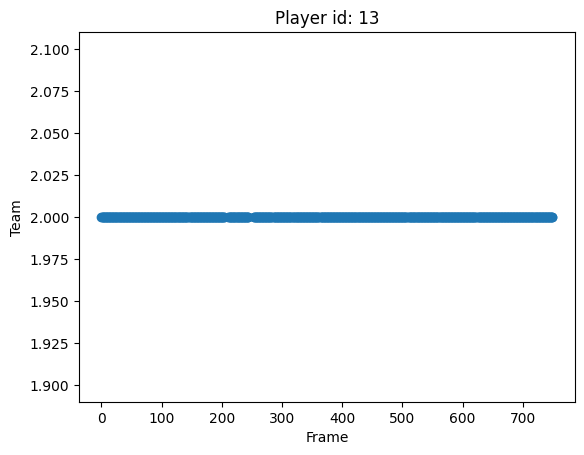

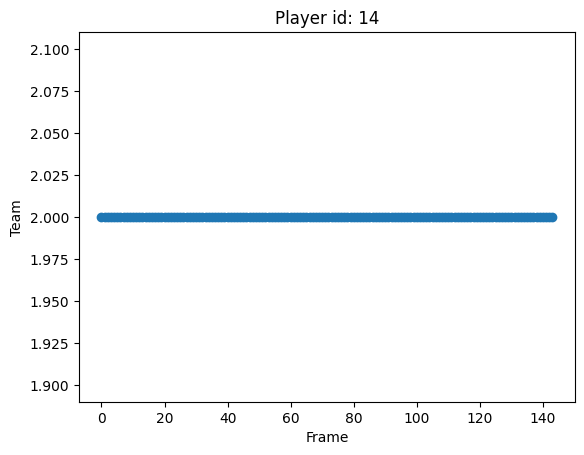

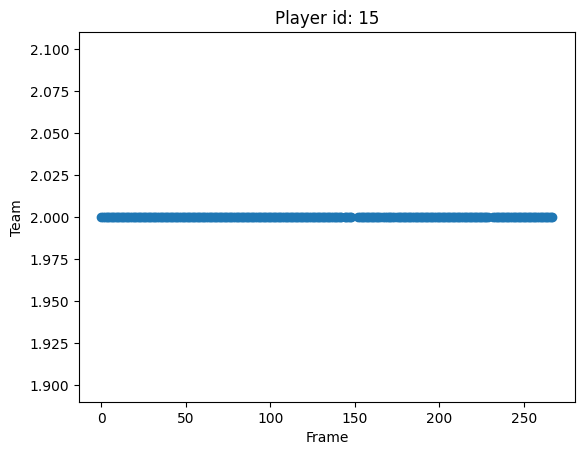

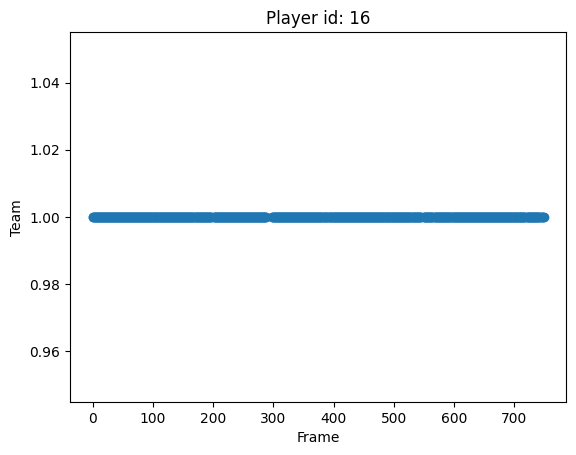

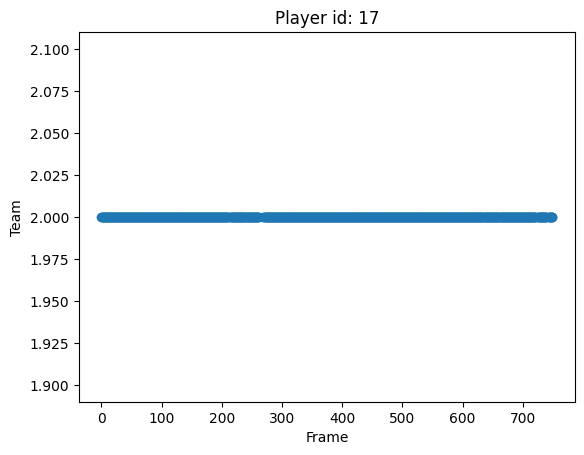

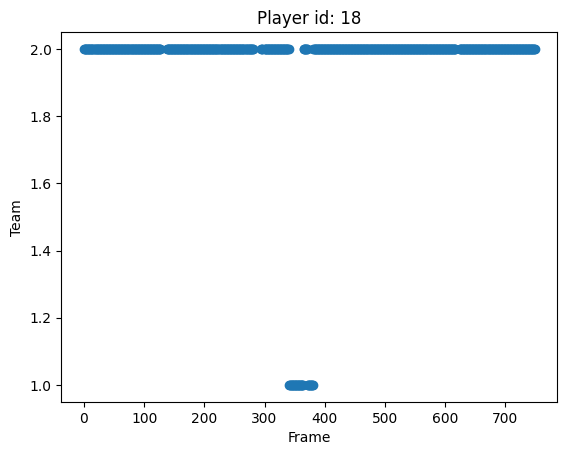

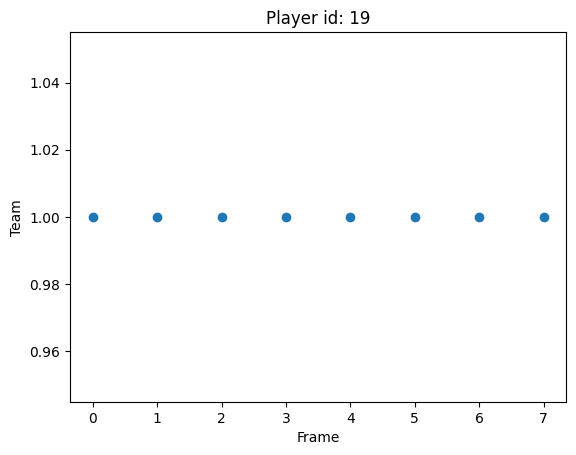

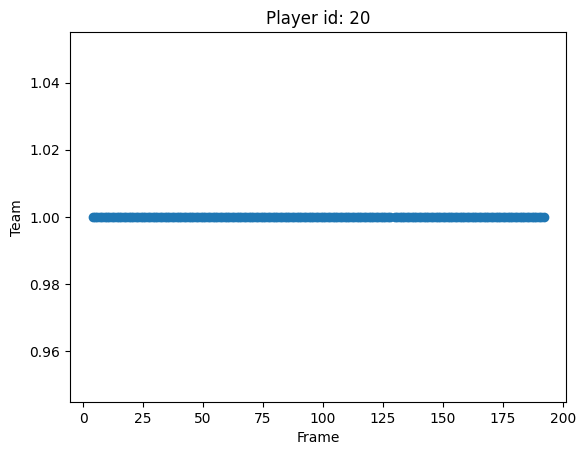

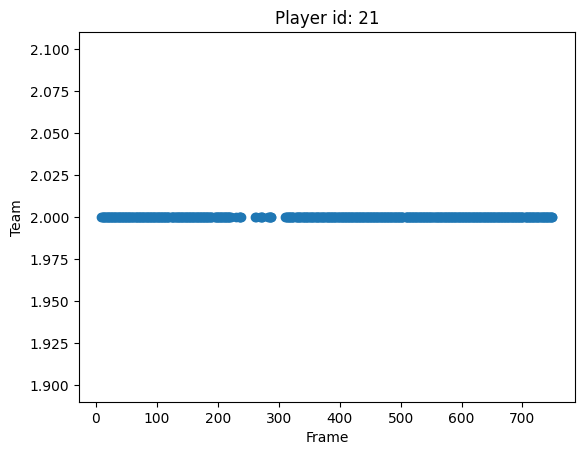

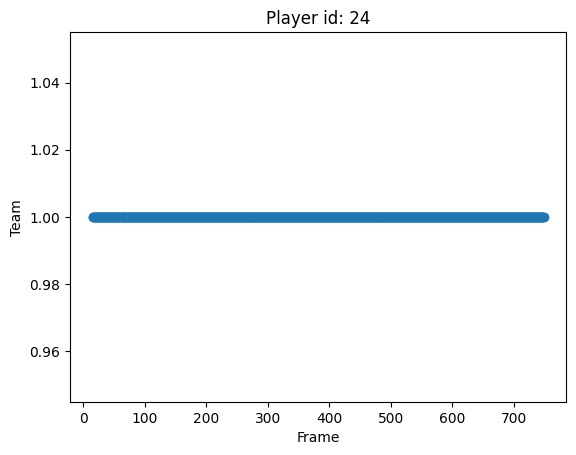

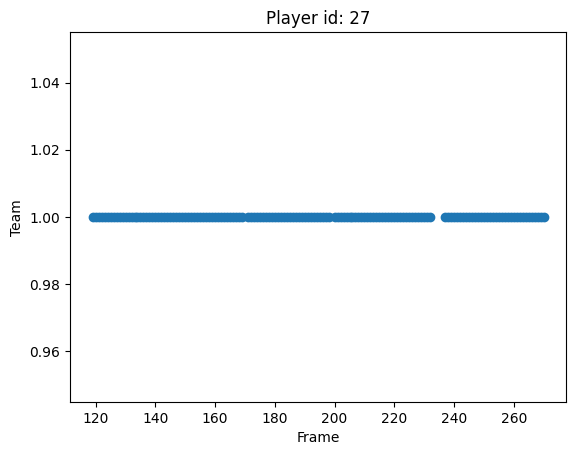

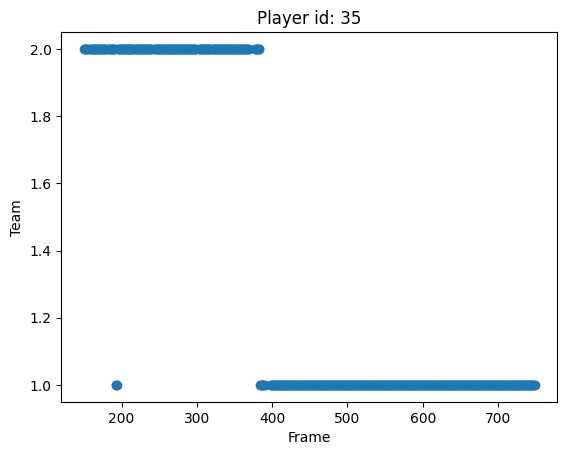

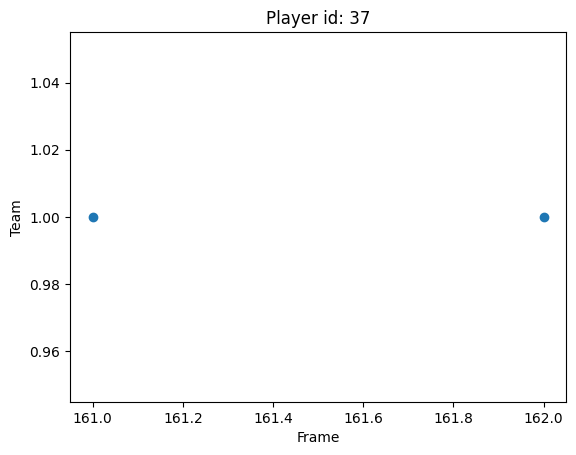

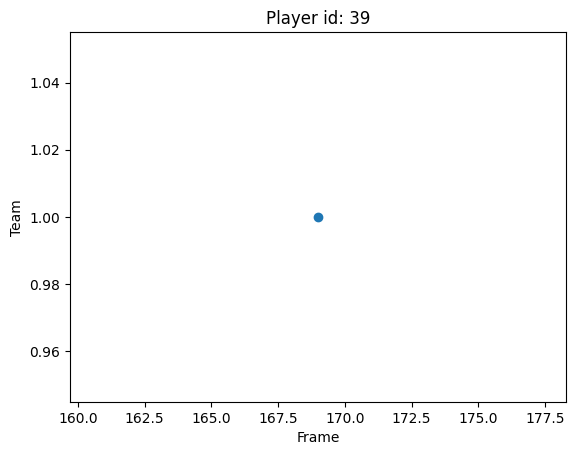

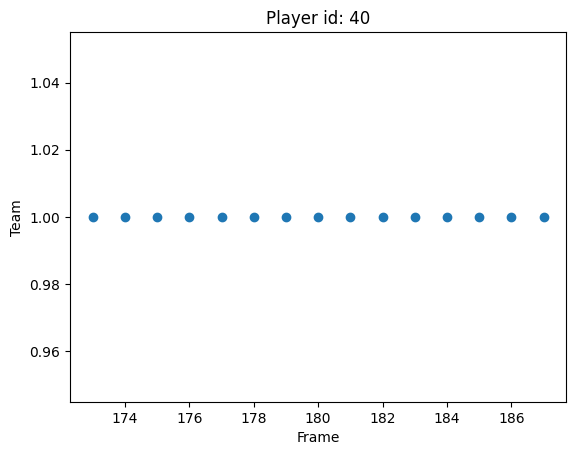

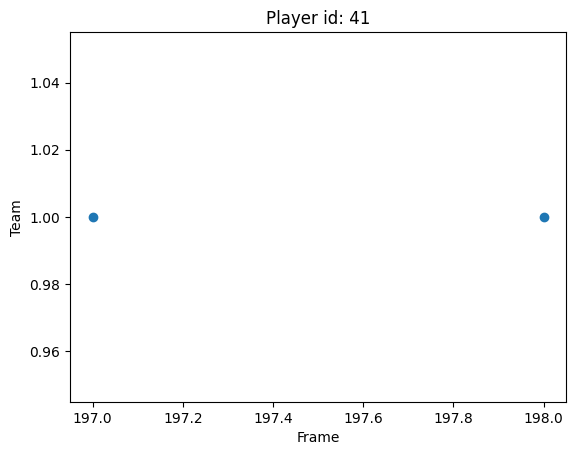

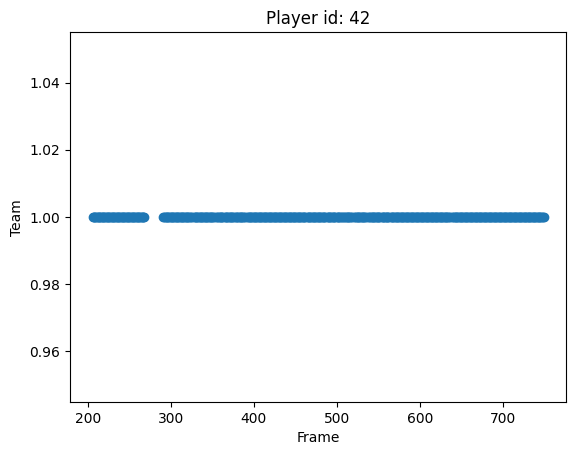

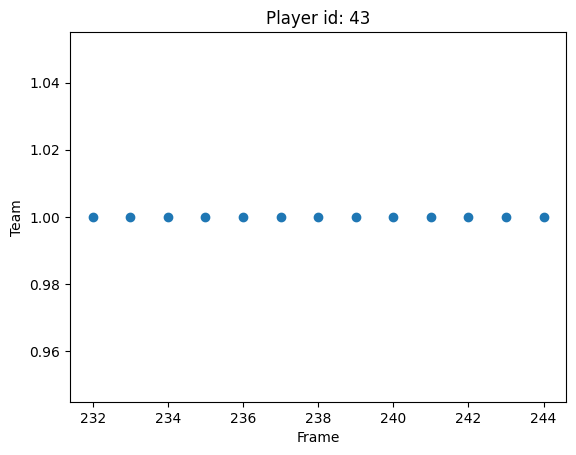

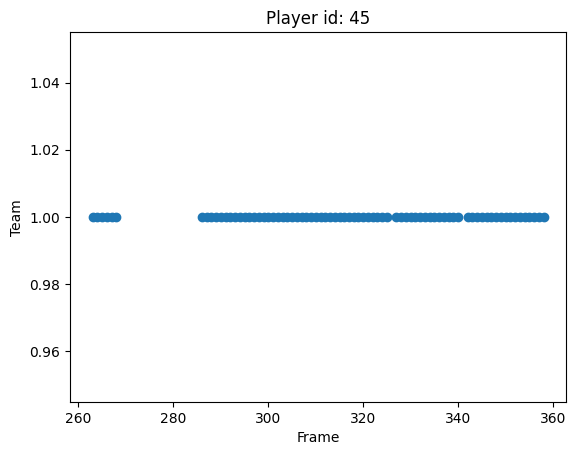

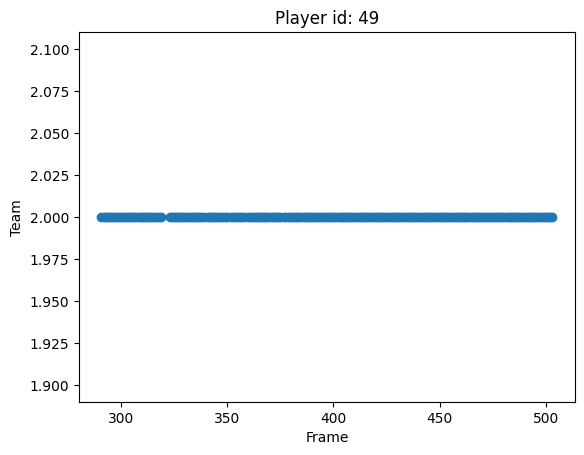

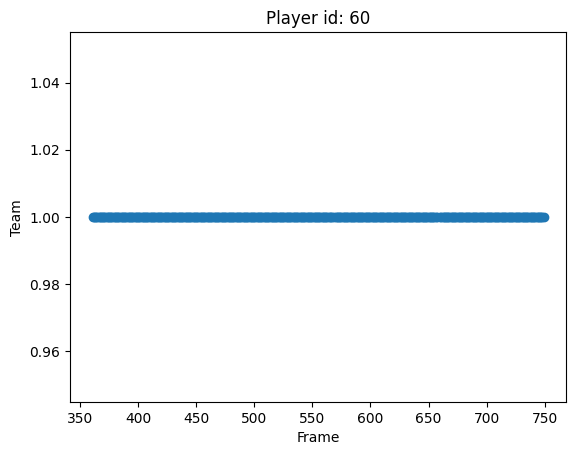

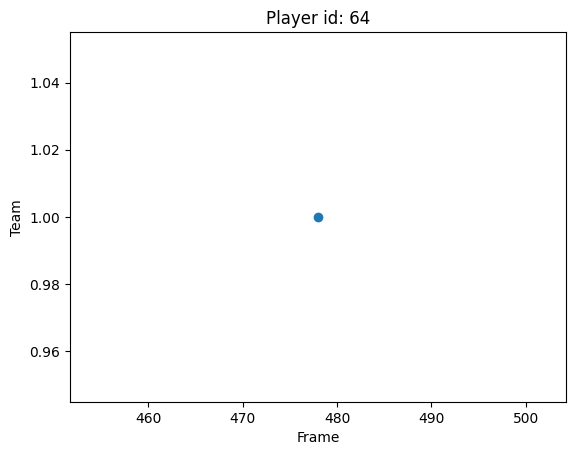

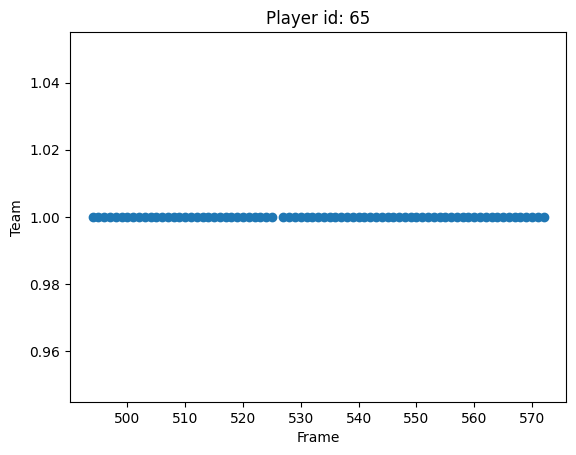

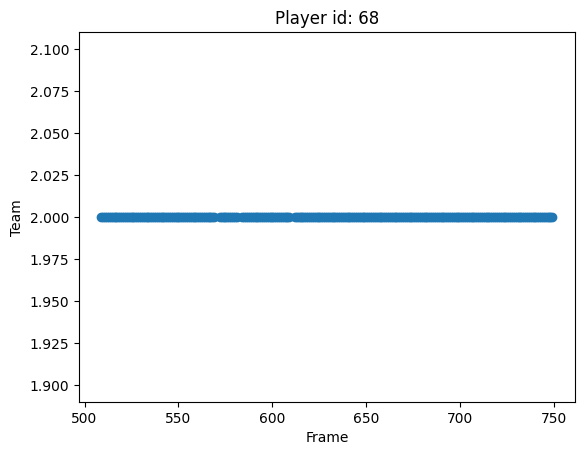

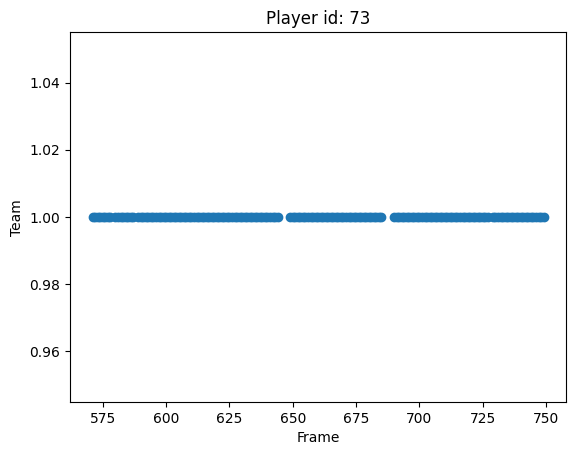

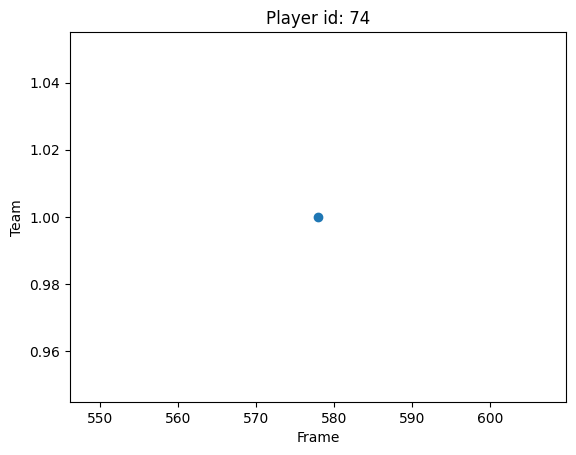

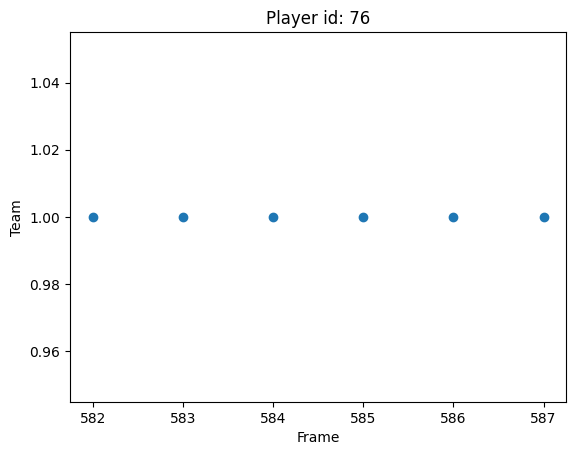

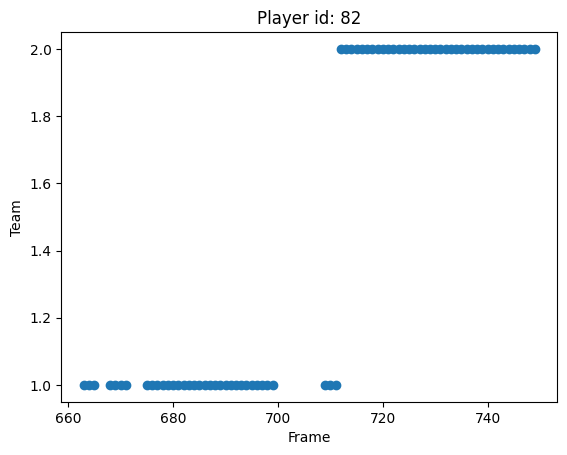

In [10]:
for tracking_id in reformatted_tracks.keys():
    display_player_team(reformatted_tracks, player_id=tracking_id)

In [11]:
def detect_team_switches(reformatted_tracks):
    switches = {}
    for player_id, player_data in reformatted_tracks.items():
        previous_team = None
        for frame, team in zip(player_data['num_frames'], player_data['team_id']):
            if previous_team is not None and team != previous_team:
                if player_id not in switches:
                    switches[player_id] = []
                switches[player_id].append((frame, previous_team, team))
            previous_team = team
    return switches

In [12]:
switches = detect_team_switches(reformatted_tracks)
print(switches)

{1: [(398, 1, 2)], 7: [(681, 1, 2), (709, 2, 1)], 18: [(341, 2, 1), (365, 1, 2), (372, 2, 1), (381, 1, 2)], 35: [(192, 2, 1), (195, 1, 2), (384, 2, 1)], 82: [(712, 1, 2)]}


In [13]:
def find_switch_pairs(switches, time_window=24):
    pairs = []
    ids = list(switches.keys())
    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            id1, id2 = ids[i], ids[j]
            switches_id1 = switches[id1]
            switches_id2 = switches[id2]

            # On compare les frames de transition entre id1 et id2
            for switch1 in switches_id1:
                for switch2 in switches_id2:
                    if abs(switch1[0] - switch2[0]) <= time_window:
                        pairs.append((id1, id2, switch1[0], switch2[0]))
    return pairs

In [14]:
pairs = find_switch_pairs(switches)
print(pairs)

[(1, 18, 398, 381), (1, 35, 398, 384), (7, 82, 709, 712), (18, 35, 365, 384), (18, 35, 372, 384), (18, 35, 381, 384)]


In [15]:
def filter_switch_pairs_by_proximity(switch_pairs, reformatted_tracks, distance_threshold=50):
    plausible_switch_pairs = []
    for id1, id2, frame1, frame2 in switch_pairs:
        bbox1 = reformatted_tracks[id1]['bbox'][reformatted_tracks[id1]['num_frames'].index(frame1)]
        bbox2 = reformatted_tracks[id2]['bbox'][reformatted_tracks[id2]['num_frames'].index(frame2)]
    
        center1 = ((bbox1[0] + bbox1[2]) / 2, (bbox1[1] + bbox1[3]) / 2)
        center2 = ((bbox2[0] + bbox2[2]) / 2, (bbox2[1] + bbox2[3]) / 2)

        distance = np.linalg.norm(np.array(center1) - np.array(center2))

        if distance < distance_threshold:
            plausible_switch_pairs.append((id1, id2, frame1, frame2, distance))

    return plausible_switch_pairs

In [16]:
plausible_switch_pairs = filter_switch_pairs_by_proximity(pairs, reformatted_tracks)
print(plausible_switch_pairs)

[(1, 35, 398, 384, 31.565316521283854), (7, 82, 709, 712, 4.996863006413723)]


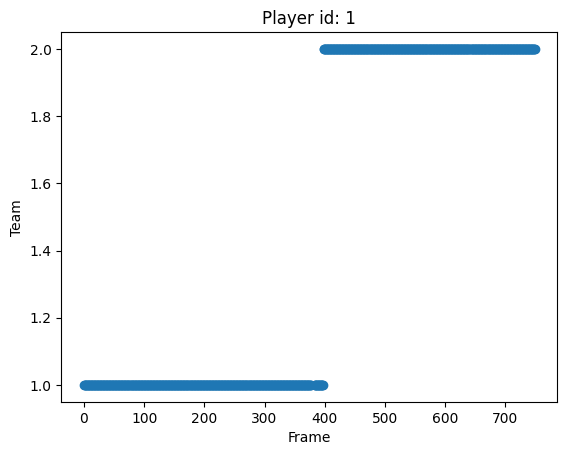

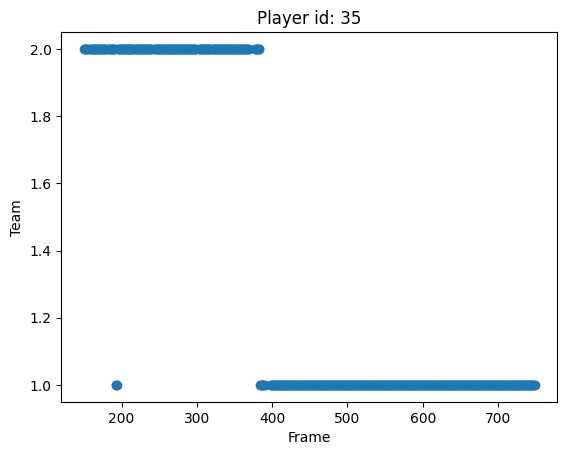

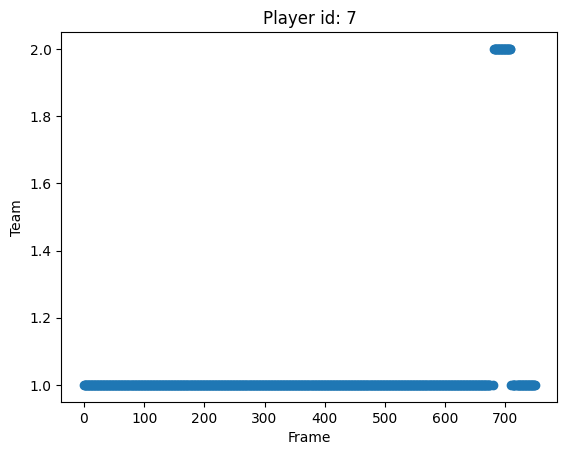

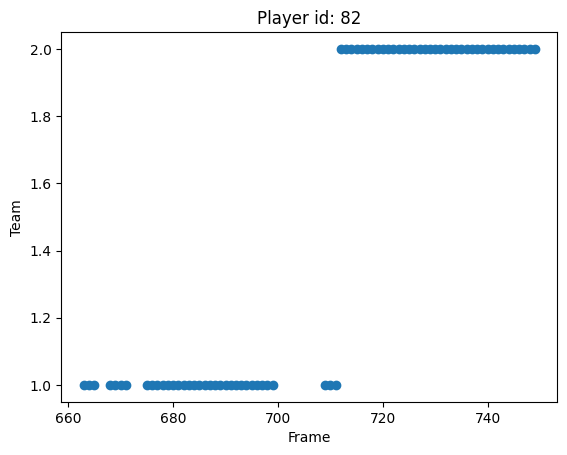

In [17]:
display_player_team(reformatted_tracks, player_id=1)
display_player_team(reformatted_tracks, player_id=35)
display_player_team(reformatted_tracks, player_id=7)
display_player_team(reformatted_tracks, player_id=82)

In [18]:
print(reformatted_tracks[1].keys())

dict_keys(['num_frames', 'team_id', 'bbox'])


In [19]:
def apply_switch_corrections(plausible_switch_pairs, reformatted_tracks):
    for id1, id2, frame1, frame2, distance in plausible_switch_pairs:
        # Diviser les données de id1 avant et après frame1
        frames_id1_before = []
        team_id1_before = []
        bbox_id1_before = []

        frames_id1_after = []
        team_id1_after = []
        bbox_id1_after = []

        for idx, frame in enumerate(reformatted_tracks[id1]['num_frames']):
            if frame < frame1:
                frames_id1_before.append(frame)
                team_id1_before.append(reformatted_tracks[id1]['team_id'][idx])
                bbox_id1_before.append(reformatted_tracks[id1]['bbox'][idx])
            else:
                frames_id1_after.append(frame)
                team_id1_after.append(reformatted_tracks[id1]['team_id'][idx])
                bbox_id1_after.append(reformatted_tracks[id1]['bbox'][idx])

        # Diviser les données de id2 avant et après frame2
        frames_id2_before = []
        team_id2_before = []
        bbox_id2_before = []

        frames_id2_after = []
        team_id2_after = []
        bbox_id2_after = []

        for idx, frame in enumerate(reformatted_tracks[id2]['num_frames']):
            if frame < frame2:
                frames_id2_before.append(frame)
                team_id2_before.append(reformatted_tracks[id2]['team_id'][idx])
                bbox_id2_before.append(reformatted_tracks[id2]['bbox'][idx])
            else:
                frames_id2_after.append(frame)
                team_id2_after.append(reformatted_tracks[id2]['team_id'][idx])
                bbox_id2_after.append(reformatted_tracks[id2]['bbox'][idx])

        # Appliquer le switch des parties après les frames de switch
        # On met les données de id1 après frame1 à id2 et inversement
        reformatted_tracks[id1]['num_frames'] = frames_id1_before + frames_id2_after
        reformatted_tracks[id1]['team_id'] = team_id1_before + team_id2_after
        reformatted_tracks[id1]['bbox'] = bbox_id1_before + bbox_id2_after

        reformatted_tracks[id2]['num_frames'] = frames_id2_before + frames_id1_after
        reformatted_tracks[id2]['team_id'] = team_id2_before + team_id1_after
        reformatted_tracks[id2]['bbox'] = bbox_id2_before + bbox_id1_after

    return reformatted_tracks


In [20]:
reformatted_tracks = apply_switch_corrections(plausible_switch_pairs, reformatted_tracks)


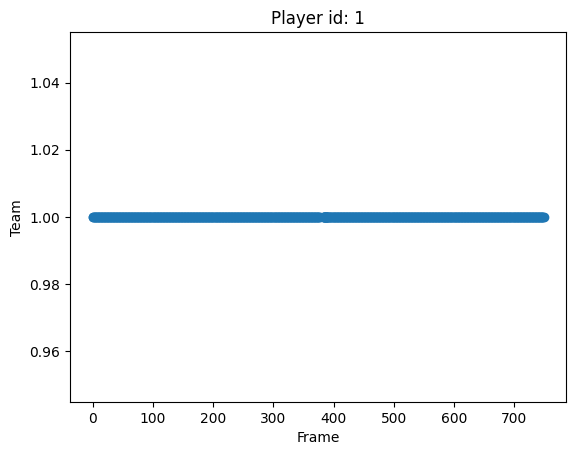

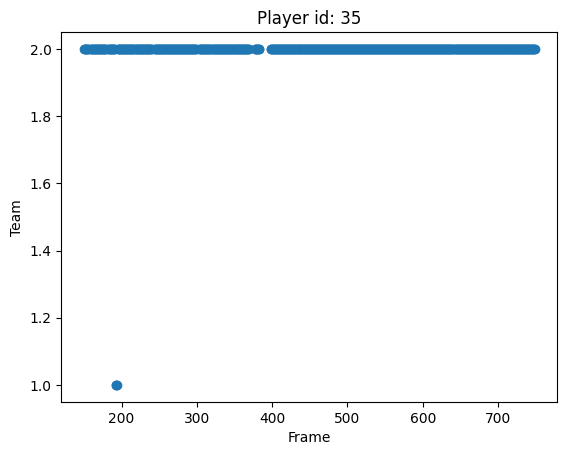

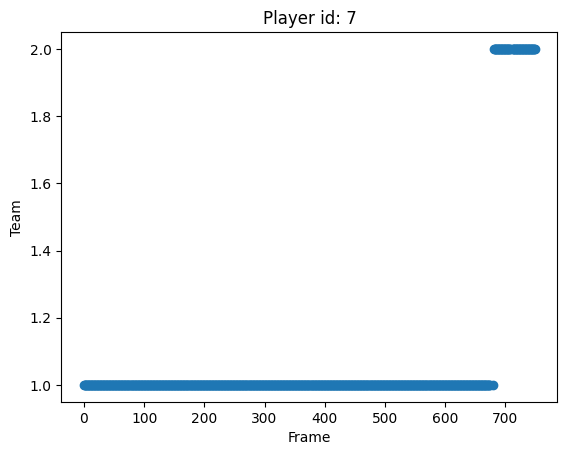

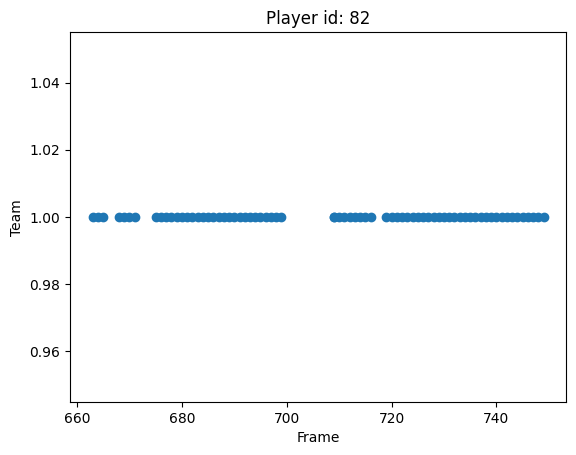

In [21]:
display_player_team(reformatted_tracks, player_id=1)
display_player_team(reformatted_tracks, player_id=35)
display_player_team(reformatted_tracks, player_id=7)
display_player_team(reformatted_tracks, player_id=82)

In [22]:
def merge_id(reformatted_tracks, frame_threshold=24, distance_threshold=50):
    pairs = []

    for tracking_id, track_data in reformatted_tracks.items():
        last_frame = track_data['num_frames'][-1]
        team_id = track_data['team_id'][-1]
        bbox = track_data['bbox'][-1]

        if last_frame >= 749 - frame_threshold: # coder en dur  !!!
            continue

        candidates_id = []

        for next_id, next_data in reformatted_tracks.items():

            if next_id == tracking_id or next_data['team_id'][0] != team_id:
                continue
            
            first_frame = next_data['num_frames'][0]
            if first_frame <= last_frame or first_frame > last_frame + frame_threshold:
                continue

            center_last = ((bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2)
            center_first = ((next_data['bbox'][0][0] + next_data['bbox'][0][2]) / 2, 
                           (next_data['bbox'][0][1] + next_data['bbox'][0][3]) / 2)
            
            distance = np.linalg.norm(np.array(center_last) - np.array(center_first))

            if distance < distance_threshold:
                candidates_id.append(next_id)
            
        if len(candidates_id) != 0:
            pairs.append((tracking_id, min(candidates_id)))

    combined = []

    for pair in pairs:
        found = False
        for group in combined:
            if pair[0] in group or pair[1] in group:
                group.update(pair)
                found = True
                break
        if not found:
            combined.append(set(pair))

    return [tuple(sorted(group)) for group in combined]


In [23]:
combined_pairs = merge_id(reformatted_tracks)
print(combined_pairs)

[(14, 35), (15, 49, 68), (20, 42), (37, 39, 40, 41), (43, 45), (65, 74, 76)]


In [24]:
print(len(reformatted_tracks))

40


In [25]:
def merge_tracks_in_place(reformatted_tracks, combined_pairs):
    for group in combined_pairs:
        # Initialiser les listes fusionnées pour num_frames, team_id, et bbox
        merged_num_frames = []
        merged_team_id = []
        merged_bbox = []

        # Fusionner les données de chaque identifiant dans le groupe
        for tracking_id in group:
            merged_num_frames.extend(reformatted_tracks[tracking_id]['num_frames'])
            merged_team_id.extend(reformatted_tracks[tracking_id]['team_id'])
            merged_bbox.extend(reformatted_tracks[tracking_id]['bbox'])

        # Trier les données par num_frames pour garder l'ordre chronologique
        sorted_data = sorted(zip(merged_num_frames, merged_team_id, merged_bbox), key=lambda x: x[0])
        merged_num_frames, merged_team_id, merged_bbox = zip(*sorted_data)

        # Choisir un identifiant de base (le plus petit identifiant du groupe) pour conserver les données fusionnées
        base_id = min(group)
        reformatted_tracks[base_id] = {
            'num_frames': list(merged_num_frames),
            'team_id': list(merged_team_id),
            'bbox': list(merged_bbox)
        }

        # Supprimer les autres identifiants du groupe fusionné
        for tracking_id in group:
            if tracking_id != base_id:
                del reformatted_tracks[tracking_id]

    return reformatted_tracks


In [27]:
reformatted_tracks = merge_tracks_in_place(reformatted_tracks, combined_pairs)

In [28]:
print(len(reformatted_tracks))

30


In [ ]:
print(reformatted_tracks.keys())

In [29]:
def find_players_with_multiple_teams(reformatted_tracks):
    player_teams = {}
    for player_id, track_info in reformatted_tracks.items():
        teams = set(track_info['team_id'])
        player_teams[player_id] = teams

    players_with_multiple_teams = {
        player_id: teams
        for player_id, teams in player_teams.items()
        if len(teams) > 1
    }

    return players_with_multiple_teams

In [30]:
players_with_multiple_teams = find_players_with_multiple_teams(reformatted_tracks)
print(players_with_multiple_teams)

{7: {1, 2}, 14: {1, 2}, 18: {1, 2}}
